## The problematic eigenvalues for BDF6

Define
$$
\mu(x,\Delta x)=\left\{\left|\frac {\left|\xi(\Delta x \lambda)\right|-1}{\Delta x}\right|:\lambda\in \sigma\left(A+xB\right)\right\}.
$$

The following plots show for each value of $x\in 13,12,\cdots,-9,-10$, how the (normalized) number of problematic eigenvalues (outside of the absolute stability region of BDF3) change with respect to $\Delta x$, where the number of Fourier modes is fixed at $8000$ and $\beta=2$ for all plots. Besides, for each value of $\Delta x$, for those problematic eigenvalues, we also compute the mean of $\mu(x,\Delta x)$.

In [1]:
using TracyWidomBeta,LinearAlgebra,Statistics,SparseArrays,Distributions,Trapz,ApproxFun,SpecialFunctions
using RandomMatrices,Plots,LaTeXStrings,TypedTables,StatsBase,FFTW

In [2]:
ρ = (α,z) -> (z.^(length(α)-1:-1:0))'*α
σ = (β,z) -> (z.^(length(β)-1:-1:0))'*β
R = (α,β,z) -> ρ(α,z)/σ(β,z)
function find_roots(c) # supposing that the leading order coefficient is 1
    # c contains the remaining coefficients
    r = length(c)
    A = zeros(Complex{Float64},r,r)
    A[1,:] = -c
    A[2:end,1:end-1] = A[2:end,1:end-1] + I # add identity matrix to lower-left block
    return eigvals(A)
end
function compute_roots(α,β,z)
    r = length(α)-1
    c = α-z*β
    if α[1]-z*β[1] ≈ 0.
        λ = find_roots(c[3:end]/c[2])
    else
        λ = find_roots(c[2:end]/c[1]) # let's suppose that first and second coefficients don't vanish simultaneously
    end
    return λ
end
function check_condition(λ)
    if maximum(abs.(λ)) > 1
        return 0
    else
        for i = 1:length(λ)
            if abs(λ[i]) ≈ 1. && sum(map(t -> λ[i] ≈ t,λ)) > 1
                return 0
            end
        end
    end
    return 1
end
function check_condition2(λ)
    ξ_rest=zeros(ComplexF64,0)
    for i=1:length(λ)
        if abs(λ[i])>1
            append!(ξ_rest,λ[i])
        elseif abs(λ[i]) ≈ 1. && sum(map(t -> λ[i] ≈ t,λ)) > 1
            append!(ξ_rest,λ[i])
        end
    end
    return ξ_rest
end
function root_condition(α,β,z)
    return compute_roots(α,β,z) |> check_condition
end

root_condition (generic function with 1 method)

Construct the matrices.

In [3]:
β=2;
M_f=1000;#just some random value
mgrid=(n,L) -> L*(1:n)/n;
θ=mgrid(M_f,pi);
M_s=8000;
h=(1/M_f)*pi;
method="spectral";
l=10;
(A,B)=TracyWidomBeta.matrix_gen(β;method,M_f,M_s,h,θ,l);

For $x=-10$, we have

In [4]:
Delta_x=[-1,-0.5,-0.4,-0.2,-0.1,-0.05,-0.04,-0.02,-0.01,-0.005,-0.004,-0.002,-0.001,-0.0005,-0.0002,-0.0001];
r_leftm10=zeros(1,length(Delta_x));r_rightm10=zeros(1,length(Delta_x));
v_leftm10=zeros(1,length(Delta_x));v_rightm10=zeros(1,length(Delta_x));
α = [147/60,-6,45/6,-400/60,225/60,-72/60,1/6];β = [1,0,0,0,0,0,0];
C=A-10*B;
Eig=eigvals(Matrix(C));
for j=1:length(Delta_x)
    z_left=zeros(ComplexF64,0);z_right=zeros(ComplexF64,0);
    ξ_left=zeros(ComplexF64,0);ξ_right=zeros(ComplexF64,0);
    Δx=Delta_x[j]
    z=Δx*Eig;
    for i=1:length(z)
        ξ=compute_roots(α,β,z[i])
        if real(z[i])>0 && check_condition(ξ)==0
            append!(z_right,z[i])
            append!(ξ_right,ξ)
        end
        if real(z[i])<0 && check_condition(ξ)==0
            append!(z_left,z[i])
            append!(ξ_left,ξ)
        end
    end
    r_leftm10[j]=length(z_left)/M_s;
    r_rightm10[j]=length(z_right)/M_s;
    if length(ξ_left)==0
        v_leftm10[j]=0
    end
    if length(ξ_right)==0
        v_rightm10[j]=0
    end
    if length(ξ_left)>0
        ξ_restl=check_condition2(ξ_left)
        μ_left=abs.((abs.(ξ_restl).-1)./Δx)
        v_leftm10[j]=mean(μ_left)
    end
    if length(ξ_right)>0
        ξ_restr=check_condition2(ξ_right)
        μ_right=abs.((abs.(ξ_restr).-1)./Δx)
        v_rightm10[j]=mean(μ_right)
    end
end

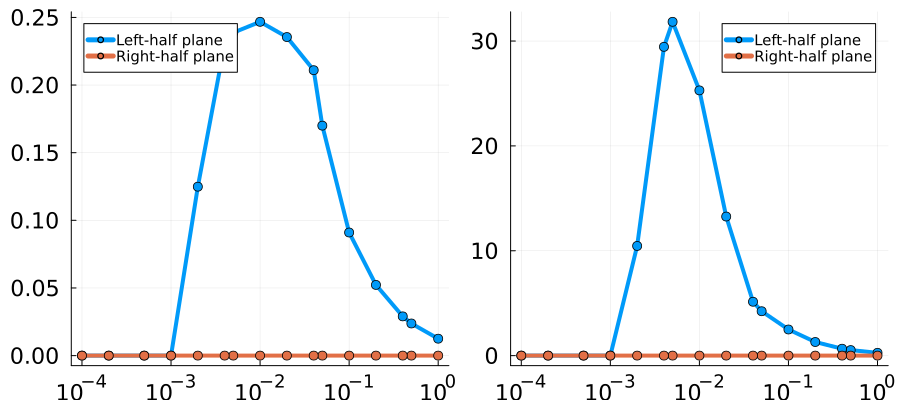

In [5]:
p_m10r=Plots.plot();
p_m10r=plot!(Delta_x.*(-1),vec(r_leftm10),lw=4,label="Left-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_m10r=plot!(Delta_x.*(-1),vec(r_rightm10),lw=4,label="Right-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_m10v=Plots.plot();
p_m10v=plot!(Delta_x.*(-1),vec(v_leftm10),lw=4,label="Left-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_m10v=plot!(Delta_x.*(-1),vec(v_rightm10),lw=4,label="Right-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
plot(p_m10r,p_m10v,size=(900,400))

In [6]:
t_m10=Table(Δx=Delta_x,ratio_left=vec(r_leftm10),mean_left=vec(v_leftm10),ratio_right=vec(r_rightm10),mean_right=vec(v_rightm10))

Table with 5 columns and 16 rows:
      Δx       ratio_left  mean_left  ratio_right  mean_right
    ┌────────────────────────────────────────────────────────
 1  │ -1.0     0.0125      0.264227   0.0          0.0
 2  │ -0.5     0.02375     0.527208   0.0          0.0
 3  │ -0.4     0.029       0.657206   0.0          0.0
 4  │ -0.2     0.05225     1.29719    0.0          0.0
 5  │ -0.1     0.091       2.48998    0.0          0.0
 6  │ -0.05    0.17        4.23241    0.0          0.0
 7  │ -0.04    0.211       5.13522    0.0          0.0
 8  │ -0.02    0.2355      13.2622    0.0          0.0
 9  │ -0.01    0.24675     25.2954    0.0          0.0
 10 │ -0.005   0.23875     31.8343    0.0          0.0
 11 │ -0.004   0.23025     29.4473    0.0          0.0
 12 │ -0.002   0.124875    10.4589    0.0          0.0
 13 │ -0.001   0.0         0.0        0.0          0.0
 14 │ -0.0005  0.0         0.0        0.0          0.0
 15 │ -0.0002  0.0         0.0        0.0          0.0
 16 │ -0.0001  0.

For $x=-9$, we have

In [7]:
Delta_x=[-1,-0.5,-0.4,-0.2,-0.1,-0.05,-0.04,-0.02,-0.01,-0.005,-0.004,-0.002,-0.001,-0.0005,-0.0002,-0.0001];
r_leftm9=zeros(1,length(Delta_x));r_rightm9=zeros(1,length(Delta_x));
v_leftm9=zeros(1,length(Delta_x));v_rightm9=zeros(1,length(Delta_x));
α = [147/60,-6,45/6,-400/60,225/60,-72/60,1/6];β = [1,0,0,0,0,0,0];
C=A-9*B;
Eig=eigvals(Matrix(C));
for j=1:length(Delta_x)
    z_left=zeros(ComplexF64,0);z_right=zeros(ComplexF64,0);
    ξ_left=zeros(ComplexF64,0);ξ_right=zeros(ComplexF64,0);
    Δx=Delta_x[j]
    z=Δx*Eig;
    for i=1:length(z)
        ξ=compute_roots(α,β,z[i])
        if real(z[i])>0 && check_condition(ξ)==0
            append!(z_right,z[i])
            append!(ξ_right,ξ)
        end
        if real(z[i])<0 && check_condition(ξ)==0
            append!(z_left,z[i])
            append!(ξ_left,ξ)
        end
    end
    r_leftm9[j]=length(z_left)/M_s;
    r_rightm9[j]=length(z_right)/M_s;
    if length(ξ_left)==0
        v_leftm9[j]=0
    end
    if length(ξ_right)==0
        v_rightm9[j]=0
    end
    if length(ξ_left)>0
        ξ_restl=check_condition2(ξ_left)
        μ_left=abs.((abs.(ξ_restl).-1)./Δx)
        v_leftm9[j]=mean(μ_left)
    end
    if length(ξ_right)>0
        ξ_restr=check_condition2(ξ_right)
        μ_right=abs.((abs.(ξ_restr).-1)./Δx)
        v_rightm9[j]=mean(μ_right)
    end
end

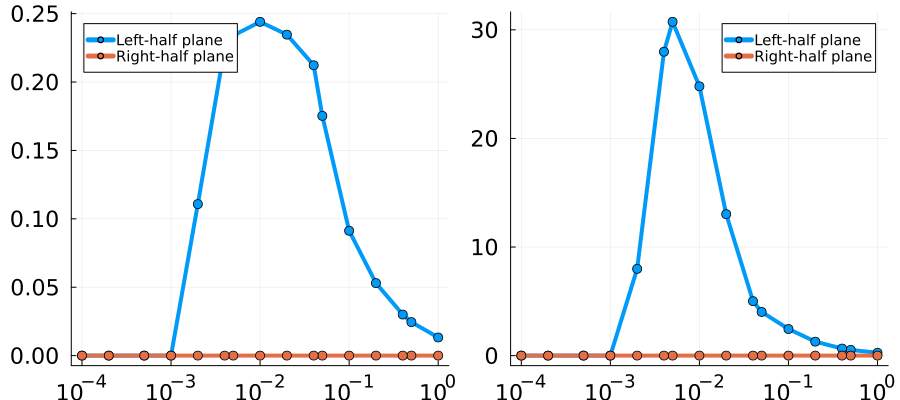

In [8]:
p_m9r=Plots.plot();
p_m9r=plot!(Delta_x.*(-1),vec(r_leftm9),lw=4,label="Left-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_m9r=plot!(Delta_x.*(-1),vec(r_rightm9),lw=4,label="Right-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_m9v=Plots.plot();
p_m9v=plot!(Delta_x.*(-1),vec(v_leftm9),lw=4,label="Left-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_m9v=plot!(Delta_x.*(-1),vec(v_rightm9),lw=4,label="Right-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
plot(p_m9r,p_m9v,size=(900,400))

In [9]:
t_m9=Table(Δx=Delta_x,ratio_left=vec(r_leftm9),mean_left=vec(v_leftm9),ratio_right=vec(r_rightm9),mean_right=vec(v_rightm9))

Table with 5 columns and 16 rows:
      Δx       ratio_left  mean_left  ratio_right  mean_right
    ┌────────────────────────────────────────────────────────
 1  │ -1.0     0.01325     0.259155   0.0          0.0
 2  │ -0.5     0.0245      0.525655   0.0          0.0
 3  │ -0.4     0.03        0.650097   0.0          0.0
 4  │ -0.2     0.053       1.285      0.0          0.0
 5  │ -0.1     0.09125     2.44977    0.0          0.0
 6  │ -0.05    0.17525     4.01978    0.0          0.0
 7  │ -0.04    0.21225     5.01398    0.0          0.0
 8  │ -0.02    0.234625    13.0229    0.0          0.0
 9  │ -0.01    0.244       24.7978    0.0          0.0
 10 │ -0.005   0.234       30.7353    0.0          0.0
 11 │ -0.004   0.225       27.9796    0.0          0.0
 12 │ -0.002   0.11075     7.98736    0.0          0.0
 13 │ -0.001   0.0         0.0        0.0          0.0
 14 │ -0.0005  0.0         0.0        0.0          0.0
 15 │ -0.0002  0.0         0.0        0.0          0.0
 16 │ -0.0001  0.

For $x=-8$, we have

In [10]:
Delta_x=[-1,-0.5,-0.4,-0.2,-0.1,-0.05,-0.04,-0.02,-0.01,-0.005,-0.004,-0.002,-0.001,-0.0005,-0.0002,-0.0001];
r_leftm8=zeros(1,length(Delta_x));r_rightm8=zeros(1,length(Delta_x));
v_leftm8=zeros(1,length(Delta_x));v_rightm8=zeros(1,length(Delta_x));
α = [147/60,-6,45/6,-400/60,225/60,-72/60,1/6];β = [1,0,0,0,0,0,0];
C=A-8*B;
Eig=eigvals(Matrix(C));
for j=1:length(Delta_x)
    z_left=zeros(ComplexF64,0);z_right=zeros(ComplexF64,0);
    ξ_left=zeros(ComplexF64,0);ξ_right=zeros(ComplexF64,0);
    Δx=Delta_x[j]
    z=Δx*Eig;
    for i=1:length(z)
        ξ=compute_roots(α,β,z[i])
        if real(z[i])>0 && check_condition(ξ)==0
            append!(z_right,z[i])
            append!(ξ_right,ξ)
        end
        if real(z[i])<0 && check_condition(ξ)==0
            append!(z_left,z[i])
            append!(ξ_left,ξ)
        end
    end
    r_leftm8[j]=length(z_left)/M_s;
    r_rightm8[j]=length(z_right)/M_s;
    if length(ξ_left)==0
        v_leftm8[j]=0
    end
    if length(ξ_right)==0
        v_rightm8[j]=0
    end
    if length(ξ_left)>0
        ξ_restl=check_condition2(ξ_left)
        μ_left=abs.((abs.(ξ_restl).-1)./Δx)
        v_leftm8[j]=mean(μ_left)
    end
    if length(ξ_right)>0
        ξ_restr=check_condition2(ξ_right)
        μ_right=abs.((abs.(ξ_restr).-1)./Δx)
        v_rightm8[j]=mean(μ_right)
    end
end

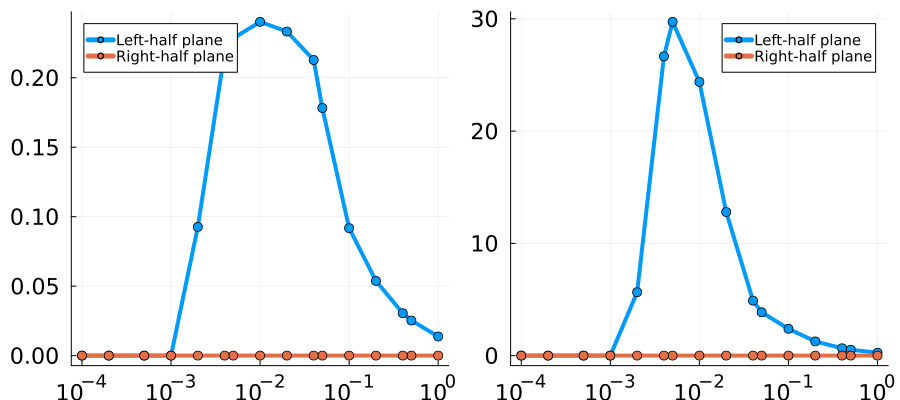

In [11]:
p_m8r=Plots.plot();
p_m8r=plot!(Delta_x.*(-1),vec(r_leftm8),lw=4,label="Left-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_m8r=plot!(Delta_x.*(-1),vec(r_rightm8),lw=4,label="Right-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_m8v=Plots.plot();
p_m8v=plot!(Delta_x.*(-1),vec(v_leftm8),lw=4,label="Left-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_m8v=plot!(Delta_x.*(-1),vec(v_rightm8),lw=4,label="Right-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
plot(p_m8r,p_m8v,size=(900,400))

In [12]:
t_m8=Table(Δx=Delta_x,ratio_left=vec(r_leftm8),mean_left=vec(v_leftm8),ratio_right=vec(r_rightm8),mean_right=vec(v_rightm8))

Table with 5 columns and 16 rows:
      Δx       ratio_left  mean_left  ratio_right  mean_right
    ┌────────────────────────────────────────────────────────
 1  │ -1.0     0.01375     0.26015    0.0          0.0
 2  │ -0.5     0.02525     0.523351   0.0          0.0
 3  │ -0.4     0.0305      0.652285   0.0          0.0
 4  │ -0.2     0.05375     1.26518    0.0          0.0
 5  │ -0.1     0.09175     2.38658    0.0          0.0
 6  │ -0.05    0.17825     3.85619    0.0          0.0
 7  │ -0.04    0.21275     4.89713    0.0          0.0
 8  │ -0.02    0.23325     12.7921    0.0          0.0
 9  │ -0.01    0.24025     24.3811    0.0          0.0
 10 │ -0.005   0.228375    29.7329    0.0          0.0
 11 │ -0.004   0.218375    26.6594    0.0          0.0
 12 │ -0.002   0.092625    5.64761    0.0          0.0
 13 │ -0.001   0.0         0.0        0.0          0.0
 14 │ -0.0005  0.0         0.0        0.0          0.0
 15 │ -0.0002  0.0         0.0        0.0          0.0
 16 │ -0.0001  0.

For $x=-7$, we have

In [13]:
Delta_x=[-1,-0.5,-0.4,-0.2,-0.1,-0.05,-0.04,-0.02,-0.01,-0.005,-0.004,-0.002,-0.001,-0.0005,-0.0002,-0.0001];
r_leftm7=zeros(1,length(Delta_x));r_rightm7=zeros(1,length(Delta_x));
v_leftm7=zeros(1,length(Delta_x));v_rightm7=zeros(1,length(Delta_x));
α = [147/60,-6,45/6,-400/60,225/60,-72/60,1/6];β = [1,0,0,0,0,0,0];
C=A-7*B;
Eig=eigvals(Matrix(C));
for j=1:length(Delta_x)
    z_left=zeros(ComplexF64,0);z_right=zeros(ComplexF64,0);
    ξ_left=zeros(ComplexF64,0);ξ_right=zeros(ComplexF64,0);
    Δx=Delta_x[j]
    z=Δx*Eig;
    for i=1:length(z)
        ξ=compute_roots(α,β,z[i])
        if real(z[i])>0 && check_condition(ξ)==0
            append!(z_right,z[i])
            append!(ξ_right,ξ)
        end
        if real(z[i])<0 && check_condition(ξ)==0
            append!(z_left,z[i])
            append!(ξ_left,ξ)
        end
    end
    r_leftm7[j]=length(z_left)/M_s;
    r_rightm7[j]=length(z_right)/M_s;
    if length(ξ_left)==0
        v_leftm7[j]=0
    end
    if length(ξ_right)==0
        v_rightm7[j]=0
    end
    if length(ξ_left)>0
        ξ_restl=check_condition2(ξ_left)
        μ_left=abs.((abs.(ξ_restl).-1)./Δx)
        v_leftm7[j]=mean(μ_left)
    end
    if length(ξ_right)>0
        ξ_restr=check_condition2(ξ_right)
        μ_right=abs.((abs.(ξ_restr).-1)./Δx)
        v_rightm7[j]=mean(μ_right)
    end
end

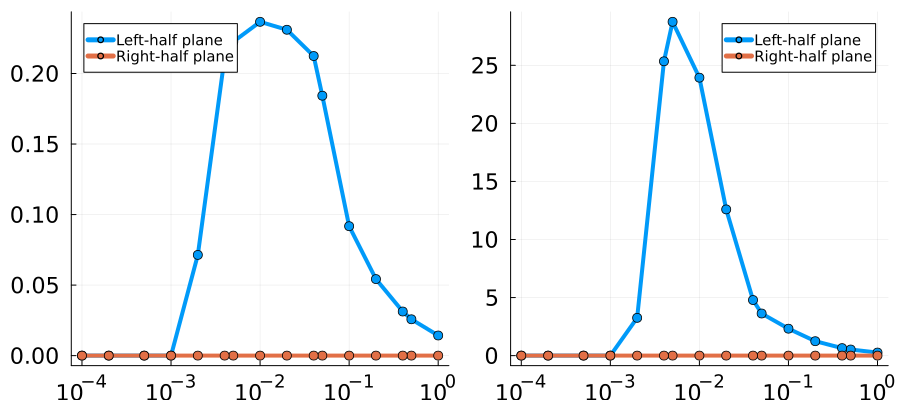

In [14]:
p_m7r=Plots.plot();
p_m7r=plot!(Delta_x.*(-1),vec(r_leftm7),lw=4,label="Left-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_m7r=plot!(Delta_x.*(-1),vec(r_rightm7),lw=4,label="Right-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_m7v=Plots.plot();
p_m7v=plot!(Delta_x.*(-1),vec(v_leftm7),lw=4,label="Left-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_m7v=plot!(Delta_x.*(-1),vec(v_rightm7),lw=4,label="Right-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
plot(p_m7r,p_m7v,size=(900,400))

In [15]:
t_m7=Table(Δx=Delta_x,ratio_left=vec(r_leftm7),mean_left=vec(v_leftm7),ratio_right=vec(r_rightm7),mean_right=vec(v_rightm7))

Table with 5 columns and 16 rows:
      Δx       ratio_left  mean_left  ratio_right  mean_right
    ┌────────────────────────────────────────────────────────
 1  │ -1.0     0.01425     0.261996   0.0          0.0
 2  │ -0.5     0.02575     0.524426   0.0          0.0
 3  │ -0.4     0.03125     0.645446   0.0          0.0
 4  │ -0.2     0.05425     1.2408     0.0          0.0
 5  │ -0.1     0.09175     2.31736    0.0          0.0
 6  │ -0.05    0.18425     3.62578    0.0          0.0
 7  │ -0.04    0.212375    4.78665    0.0          0.0
 8  │ -0.02    0.231       12.5919    0.0          0.0
 9  │ -0.01    0.236625    23.936     0.0          0.0
 10 │ -0.005   0.2225      28.7466    0.0          0.0
 11 │ -0.004   0.2115      25.3472    0.0          0.0
 12 │ -0.002   0.071375    3.25132    0.0          0.0
 13 │ -0.001   0.0         0.0        0.0          0.0
 14 │ -0.0005  0.0         0.0        0.0          0.0
 15 │ -0.0002  0.0         0.0        0.0          0.0
 16 │ -0.0001  0.

For $x=-6$, we have

In [16]:
Delta_x=[-1,-0.5,-0.4,-0.2,-0.1,-0.05,-0.04,-0.02,-0.01,-0.005,-0.004,-0.002,-0.001,-0.0005,-0.0002,-0.0001];
r_leftm6=zeros(1,length(Delta_x));r_rightm6=zeros(1,length(Delta_x));
v_leftm6=zeros(1,length(Delta_x));v_rightm6=zeros(1,length(Delta_x));
α = [147/60,-6,45/6,-400/60,225/60,-72/60,1/6];β = [1,0,0,0,0,0,0];
C=A-6*B;
Eig=eigvals(Matrix(C));
for j=1:length(Delta_x)
    z_left=zeros(ComplexF64,0);z_right=zeros(ComplexF64,0);
    ξ_left=zeros(ComplexF64,0);ξ_right=zeros(ComplexF64,0);
    Δx=Delta_x[j]
    z=Δx*Eig;
    for i=1:length(z)
        ξ=compute_roots(α,β,z[i])
        if real(z[i])>0 && check_condition(ξ)==0
            append!(z_right,z[i])
            append!(ξ_right,ξ)
        end
        if real(z[i])<0 && check_condition(ξ)==0
            append!(z_left,z[i])
            append!(ξ_left,ξ)
        end
    end
    r_leftm6[j]=length(z_left)/M_s;
    r_rightm6[j]=length(z_right)/M_s;
    if length(ξ_left)==0
        v_leftm6[j]=0
    end
    if length(ξ_right)==0
        v_rightm6[j]=0
    end
    if length(ξ_left)>0
        ξ_restl=check_condition2(ξ_left)
        μ_left=abs.((abs.(ξ_restl).-1)./Δx)
        v_leftm6[j]=mean(μ_left)
    end
    if length(ξ_right)>0
        ξ_restr=check_condition2(ξ_right)
        μ_right=abs.((abs.(ξ_restr).-1)./Δx)
        v_rightm6[j]=mean(μ_right)
    end
end

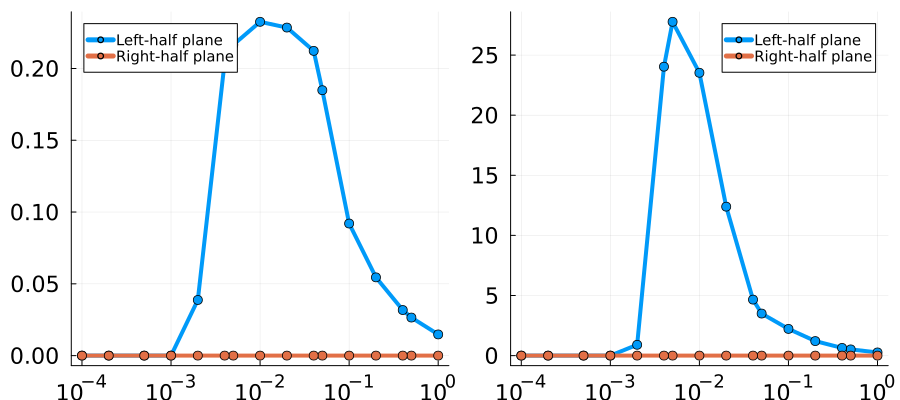

In [17]:
p_m6r=Plots.plot();
p_m6r=plot!(Delta_x.*(-1),vec(r_leftm6),lw=4,label="Left-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_m6r=plot!(Delta_x.*(-1),vec(r_rightm6),lw=4,label="Right-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_m6v=Plots.plot();
p_m6v=plot!(Delta_x.*(-1),vec(v_leftm6),lw=4,label="Left-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_m6v=plot!(Delta_x.*(-1),vec(v_rightm6),lw=4,label="Right-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
plot(p_m6r,p_m6v,size=(900,400))

In [18]:
t_m6=Table(Δx=Delta_x,ratio_left=vec(r_leftm6),mean_left=vec(v_leftm6),ratio_right=vec(r_rightm6),mean_right=vec(v_rightm6))

Table with 5 columns and 16 rows:
      Δx       ratio_left  mean_left  ratio_right  mean_right
    ┌────────────────────────────────────────────────────────
 1  │ -1.0     0.01475     0.263423   0.0          0.0
 2  │ -0.5     0.0265      0.516462   0.0          0.0
 3  │ -0.4     0.03175     0.638155   0.0          0.0
 4  │ -0.2     0.0545      1.20823    0.0          0.0
 5  │ -0.1     0.092       2.22048    0.0          0.0
 6  │ -0.05    0.184875    3.49746    0.0          0.0
 7  │ -0.04    0.21225     4.65752    0.0          0.0
 8  │ -0.02    0.2285      12.3901    0.0          0.0
 9  │ -0.01    0.2325      23.5276    0.0          0.0
 10 │ -0.005   0.2165      27.7674    0.0          0.0
 11 │ -0.004   0.2045      24.0341    0.0          0.0
 12 │ -0.002   0.03875     0.898392   0.0          0.0
 13 │ -0.001   0.0         0.0        0.0          0.0
 14 │ -0.0005  0.0         0.0        0.0          0.0
 15 │ -0.0002  0.0         0.0        0.0          0.0
 16 │ -0.0001  0.

For $x=-5$, we have

In [19]:
Delta_x=[-1,-0.5,-0.4,-0.2,-0.1,-0.05,-0.04,-0.02,-0.01,-0.005,-0.004,-0.002,-0.001,-0.0005,-0.0002,-0.0001];
r_leftm5=zeros(1,length(Delta_x));r_rightm5=zeros(1,length(Delta_x));
v_leftm5=zeros(1,length(Delta_x));v_rightm5=zeros(1,length(Delta_x));
α = [147/60,-6,45/6,-400/60,225/60,-72/60,1/6];β = [1,0,0,0,0,0,0];
C=A-5*B;
Eig=eigvals(Matrix(C));
for j=1:length(Delta_x)
    z_left=zeros(ComplexF64,0);z_right=zeros(ComplexF64,0);
    ξ_left=zeros(ComplexF64,0);ξ_right=zeros(ComplexF64,0);
    Δx=Delta_x[j]
    z=Δx*Eig;
    for i=1:length(z)
        ξ=compute_roots(α,β,z[i])
        if real(z[i])>0 && check_condition(ξ)==0
            append!(z_right,z[i])
            append!(ξ_right,ξ)
        end
        if real(z[i])<0 && check_condition(ξ)==0
            append!(z_left,z[i])
            append!(ξ_left,ξ)
        end
    end
    r_leftm5[j]=length(z_left)/M_s;
    r_rightm5[j]=length(z_right)/M_s;
    if length(ξ_left)==0
        v_leftm5[j]=0
    end
    if length(ξ_right)==0
        v_rightm5[j]=0
    end
    if length(ξ_left)>0
        ξ_restl=check_condition2(ξ_left)
        μ_left=abs.((abs.(ξ_restl).-1)./Δx)
        v_leftm5[j]=mean(μ_left)
    end
    if length(ξ_right)>0
        ξ_restr=check_condition2(ξ_right)
        μ_right=abs.((abs.(ξ_restr).-1)./Δx)
        v_rightm5[j]=mean(μ_right)
    end
end

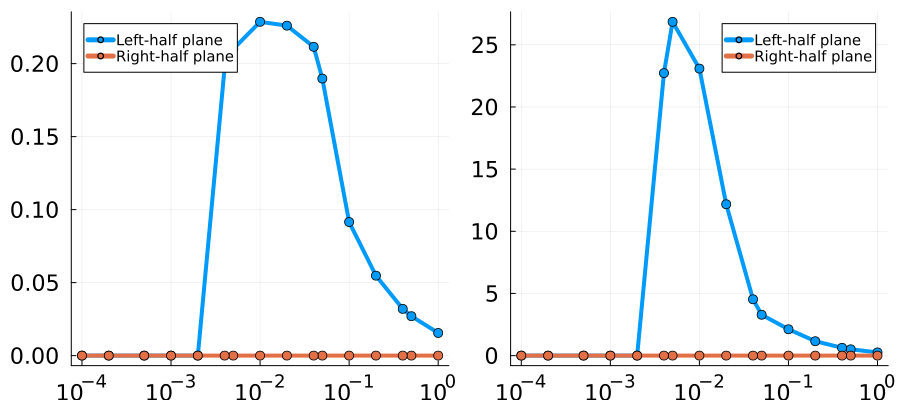

In [20]:
p_m5r=Plots.plot();
p_m5r=plot!(Delta_x.*(-1),vec(r_leftm5),lw=4,label="Left-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_m5r=plot!(Delta_x.*(-1),vec(r_rightm5),lw=4,label="Right-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_m5v=Plots.plot();
p_m5v=plot!(Delta_x.*(-1),vec(v_leftm5),lw=4,label="Left-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_m5v=plot!(Delta_x.*(-1),vec(v_rightm5),lw=4,label="Right-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
plot(p_m5r,p_m5v,size=(900,400))

In [21]:
t_m5=Table(Δx=Delta_x,ratio_left=vec(r_leftm5),mean_left=vec(v_leftm5),ratio_right=vec(r_rightm5),mean_right=vec(v_rightm5))

Table with 5 columns and 16 rows:
      Δx       ratio_left  mean_left  ratio_right  mean_right
    ┌────────────────────────────────────────────────────────
 1  │ -1.0     0.0155      0.258774   0.0          0.0
 2  │ -0.5     0.027       0.506944   0.0          0.0
 3  │ -0.4     0.032       0.626521   0.0          0.0
 4  │ -0.2     0.05475     1.15796    0.0          0.0
 5  │ -0.1     0.0915      2.11858    0.0          0.0
 6  │ -0.05    0.18975     3.28403    0.0          0.0
 7  │ -0.04    0.2115      4.53098    0.0          0.0
 8  │ -0.02    0.226       12.1763    0.0          0.0
 9  │ -0.01    0.228625    23.0864    0.0          0.0
 10 │ -0.005   0.21        26.8496    0.0          0.0
 11 │ -0.004   0.197375    22.7277    0.0          0.0
 12 │ -0.002   0.0         0.0        0.0          0.0
 13 │ -0.001   0.0         0.0        0.0          0.0
 14 │ -0.0005  0.0         0.0        0.0          0.0
 15 │ -0.0002  0.0         0.0        0.0          0.0
 16 │ -0.0001  0.

For $x=-4$, we have

In [22]:
Delta_x=[-1,-0.5,-0.4,-0.2,-0.1,-0.05,-0.04,-0.02,-0.01,-0.005,-0.004,-0.002,-0.001,-0.0005,-0.0002,-0.0001];
r_leftm4=zeros(1,length(Delta_x));r_rightm4=zeros(1,length(Delta_x));
v_leftm4=zeros(1,length(Delta_x));v_rightm4=zeros(1,length(Delta_x));
α = [147/60,-6,45/6,-400/60,225/60,-72/60,1/6];β = [1,0,0,0,0,0,0];
C=A-4*B;
Eig=eigvals(Matrix(C));
for j=1:length(Delta_x)
    z_left=zeros(ComplexF64,0);z_right=zeros(ComplexF64,0);
    ξ_left=zeros(ComplexF64,0);ξ_right=zeros(ComplexF64,0);
    Δx=Delta_x[j]
    z=Δx*Eig;
    for i=1:length(z)
        ξ=compute_roots(α,β,z[i])
        if real(z[i])>0 && check_condition(ξ)==0
            append!(z_right,z[i])
            append!(ξ_right,ξ)
        end
        if real(z[i])<0 && check_condition(ξ)==0
            append!(z_left,z[i])
            append!(ξ_left,ξ)
        end
    end
    r_leftm4[j]=length(z_left)/M_s;
    r_rightm4[j]=length(z_right)/M_s;
    if length(ξ_left)==0
        v_leftm4[j]=0
    end
    if length(ξ_right)==0
        v_rightm4[j]=0
    end
    if length(ξ_left)>0
        ξ_restl=check_condition2(ξ_left)
        μ_left=abs.((abs.(ξ_restl).-1)./Δx)
        v_leftm4[j]=mean(μ_left)
    end
    if length(ξ_right)>0
        ξ_restr=check_condition2(ξ_right)
        μ_right=abs.((abs.(ξ_restr).-1)./Δx)
        v_rightm4[j]=mean(μ_right)
    end
end

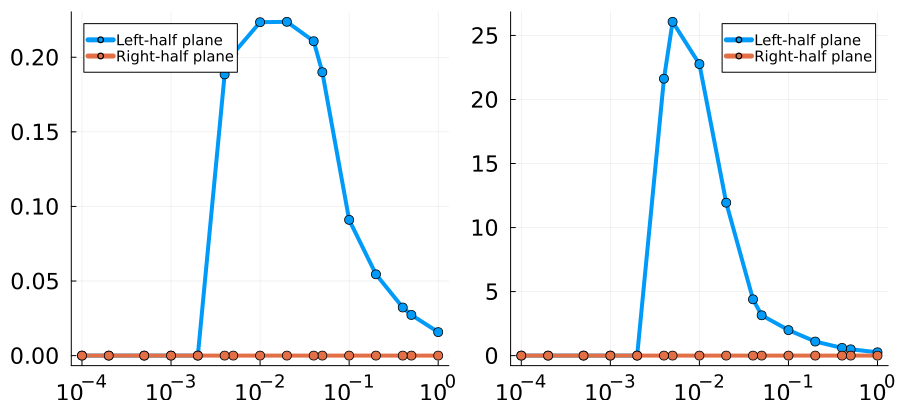

In [23]:
p_m4r=Plots.plot();
p_m4r=plot!(Delta_x.*(-1),vec(r_leftm4),lw=4,label="Left-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_m4r=plot!(Delta_x.*(-1),vec(r_rightm4),lw=4,label="Right-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_m4v=Plots.plot();
p_m4v=plot!(Delta_x.*(-1),vec(v_leftm4),lw=4,label="Left-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_m4v=plot!(Delta_x.*(-1),vec(v_rightm4),lw=4,label="Right-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
plot(p_m4r,p_m4v,size=(900,400))

In [24]:
t_m4=Table(Δx=Delta_x,ratio_left=vec(r_leftm4),mean_left=vec(v_leftm4),ratio_right=vec(r_rightm4),mean_right=vec(v_rightm4))

Table with 5 columns and 16 rows:
      Δx       ratio_left  mean_left  ratio_right  mean_right
    ┌────────────────────────────────────────────────────────
 1  │ -1.0     0.01575     0.259233   0.0          0.0
 2  │ -0.5     0.02725     0.491163   0.0          0.0
 3  │ -0.4     0.03225     0.601111   0.0          0.0
 4  │ -0.2     0.0545      1.09691    0.0          0.0
 5  │ -0.1     0.091       1.9928     0.0          0.0
 6  │ -0.05    0.19        3.14863    0.0          0.0
 7  │ -0.04    0.21075     4.3954     0.0          0.0
 8  │ -0.02    0.22375     11.94      0.0          0.0
 9  │ -0.01    0.2235      22.7672    0.0          0.0
 10 │ -0.005   0.2025      26.0651    0.0          0.0
 11 │ -0.004   0.1885      21.6224    0.0          0.0
 12 │ -0.002   0.0         0.0        0.0          0.0
 13 │ -0.001   0.0         0.0        0.0          0.0
 14 │ -0.0005  0.0         0.0        0.0          0.0
 15 │ -0.0002  0.0         0.0        0.0          0.0
 16 │ -0.0001  0.

For $x=-3$, we have

In [25]:
Delta_x=[-1,-0.5,-0.4,-0.2,-0.1,-0.05,-0.04,-0.02,-0.01,-0.005,-0.004,-0.002,-0.001,-0.0005,-0.0002,-0.0001];
r_leftm3=zeros(1,length(Delta_x));r_rightm3=zeros(1,length(Delta_x));
v_leftm3=zeros(1,length(Delta_x));v_rightm3=zeros(1,length(Delta_x));
α = [147/60,-6,45/6,-400/60,225/60,-72/60,1/6];β = [1,0,0,0,0,0,0];
C=A-3*B;
Eig=eigvals(Matrix(C));
for j=1:length(Delta_x)
    z_left=zeros(ComplexF64,0);z_right=zeros(ComplexF64,0);
    ξ_left=zeros(ComplexF64,0);ξ_right=zeros(ComplexF64,0);
    Δx=Delta_x[j]
    z=Δx*Eig;
    for i=1:length(z)
        ξ=compute_roots(α,β,z[i])
        if real(z[i])>0 && check_condition(ξ)==0
            append!(z_right,z[i])
            append!(ξ_right,ξ)
        end
        if real(z[i])<0 && check_condition(ξ)==0
            append!(z_left,z[i])
            append!(ξ_left,ξ)
        end
    end
    r_leftm3[j]=length(z_left)/M_s;
    r_rightm3[j]=length(z_right)/M_s;
    if length(ξ_left)==0
        v_leftm3[j]=0
    end
    if length(ξ_right)==0
        v_rightm3[j]=0
    end
    if length(ξ_left)>0
        ξ_restl=check_condition2(ξ_left)
        μ_left=abs.((abs.(ξ_restl).-1)./Δx)
        v_leftm3[j]=mean(μ_left)
    end
    if length(ξ_right)>0
        ξ_restr=check_condition2(ξ_right)
        μ_right=abs.((abs.(ξ_restr).-1)./Δx)
        v_rightm3[j]=mean(μ_right)
    end
end

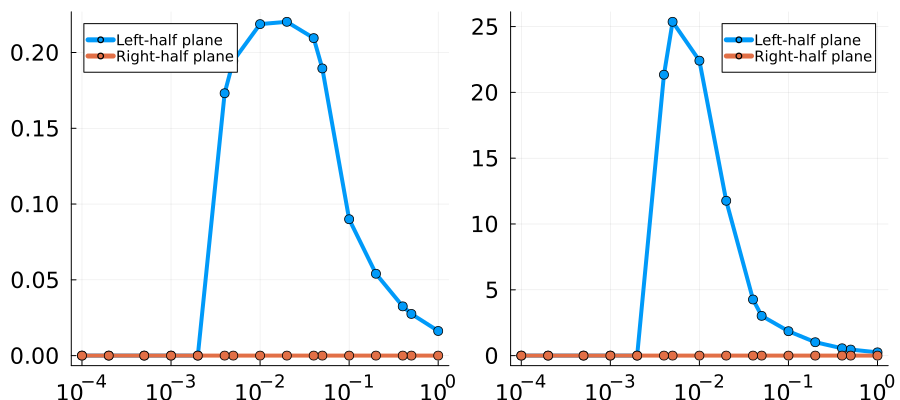

In [26]:
p_m3r=Plots.plot();
p_m3r=plot!(Delta_x.*(-1),vec(r_leftm3),lw=4,label="Left-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_m3r=plot!(Delta_x.*(-1),vec(r_rightm3),lw=4,label="Right-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_m3v=Plots.plot();
p_m3v=plot!(Delta_x.*(-1),vec(v_leftm3),lw=4,label="Left-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_m3v=plot!(Delta_x.*(-1),vec(v_rightm3),lw=4,label="Right-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
plot(p_m3r,p_m3v,size=(900,400))

In [27]:
t_m3=Table(Δx=Delta_x,ratio_left=vec(r_leftm3),mean_left=vec(v_leftm3),ratio_right=vec(r_rightm3),mean_right=vec(v_rightm3))

Table with 5 columns and 16 rows:
      Δx       ratio_left  mean_left  ratio_right  mean_right
    ┌────────────────────────────────────────────────────────
 1  │ -1.0     0.01625     0.247707   0.0          0.0
 2  │ -0.5     0.0275      0.459086   0.0          0.0
 3  │ -0.4     0.0325      0.556969   0.0          0.0
 4  │ -0.2     0.054       1.01681    0.0          0.0
 5  │ -0.1     0.09        1.8553     0.0          0.0
 6  │ -0.05    0.1895      3.01938    0.0          0.0
 7  │ -0.04    0.2095      4.2637     0.0          0.0
 8  │ -0.02    0.22025     11.7647    0.0          0.0
 9  │ -0.01    0.21875     22.4119    0.0          0.0
 10 │ -0.005   0.1945      25.3624    0.0          0.0
 11 │ -0.004   0.173125    21.3437    0.0          0.0
 12 │ -0.002   0.0         0.0        0.0          0.0
 13 │ -0.001   0.0         0.0        0.0          0.0
 14 │ -0.0005  0.0         0.0        0.0          0.0
 15 │ -0.0002  0.0         0.0        0.0          0.0
 16 │ -0.0001  0.

For $x=-2$, we have

In [28]:
Delta_x=[-1,-0.5,-0.4,-0.2,-0.1,-0.05,-0.04,-0.02,-0.01,-0.005,-0.004,-0.002,-0.001,-0.0005,-0.0002,-0.0001];
r_leftm2=zeros(1,length(Delta_x));r_rightm2=zeros(1,length(Delta_x));
v_leftm2=zeros(1,length(Delta_x));v_rightm2=zeros(1,length(Delta_x));
α = [147/60,-6,45/6,-400/60,225/60,-72/60,1/6];β = [1,0,0,0,0,0,0];
C=A-2*B;
Eig=eigvals(Matrix(C));
for j=1:length(Delta_x)
    z_left=zeros(ComplexF64,0);z_right=zeros(ComplexF64,0);
    ξ_left=zeros(ComplexF64,0);ξ_right=zeros(ComplexF64,0);
    Δx=Delta_x[j]
    z=Δx*Eig;
    for i=1:length(z)
        ξ=compute_roots(α,β,z[i])
        if real(z[i])>0 && check_condition(ξ)==0
            append!(z_right,z[i])
            append!(ξ_right,ξ)
        end
        if real(z[i])<0 && check_condition(ξ)==0
            append!(z_left,z[i])
            append!(ξ_left,ξ)
        end
    end
    r_leftm2[j]=length(z_left)/M_s;
    r_rightm2[j]=length(z_right)/M_s;
    if length(ξ_left)==0
        v_leftm2[j]=0
    end
    if length(ξ_right)==0
        v_rightm2[j]=0
    end
    if length(ξ_left)>0
        ξ_restl=check_condition2(ξ_left)
        μ_left=abs.((abs.(ξ_restl).-1)./Δx)
        v_leftm2[j]=mean(μ_left)
    end
    if length(ξ_right)>0
        ξ_restr=check_condition2(ξ_right)
        μ_right=abs.((abs.(ξ_restr).-1)./Δx)
        v_rightm2[j]=mean(μ_right)
    end
end

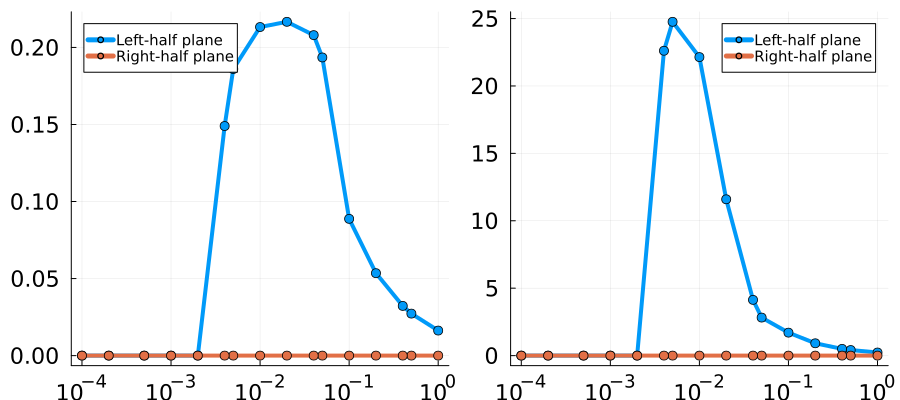

In [29]:
p_m2r=Plots.plot();
p_m2r=plot!(Delta_x.*(-1),vec(r_leftm2),lw=4,label="Left-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_m2r=plot!(Delta_x.*(-1),vec(r_rightm2),lw=4,label="Right-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_m2v=Plots.plot();
p_m2v=plot!(Delta_x.*(-1),vec(v_leftm2),lw=4,label="Left-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_m2v=plot!(Delta_x.*(-1),vec(v_rightm2),lw=4,label="Right-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
plot(p_m2r,p_m2v,size=(900,400))

In [30]:
t_m2=Table(Δx=Delta_x,ratio_left=vec(r_leftm2),mean_left=vec(v_leftm2),ratio_right=vec(r_rightm2),mean_right=vec(v_rightm2))

Table with 5 columns and 16 rows:
      Δx       ratio_left  mean_left  ratio_right  mean_right
    ┌────────────────────────────────────────────────────────
 1  │ -1.0     0.01625     0.229165   0.0          0.0
 2  │ -0.5     0.02725     0.413248   0.0          0.0
 3  │ -0.4     0.03225     0.498296   0.0          0.0
 4  │ -0.2     0.0535      0.913726   0.0          0.0
 5  │ -0.1     0.08875     1.70268    0.0          0.0
 6  │ -0.05    0.1935      2.81972    0.0          0.0
 7  │ -0.04    0.208       4.1331     0.0          0.0
 8  │ -0.02    0.216625    11.5945    0.0          0.0
 9  │ -0.01    0.21325     22.1418    0.0          0.0
 10 │ -0.005   0.186       24.7577    0.0          0.0
 11 │ -0.004   0.149       22.6108    0.0          0.0
 12 │ -0.002   0.0         0.0        0.0          0.0
 13 │ -0.001   0.0         0.0        0.0          0.0
 14 │ -0.0005  0.0         0.0        0.0          0.0
 15 │ -0.0002  0.0         0.0        0.0          0.0
 16 │ -0.0001  0.

For $x=-1$, we have

In [31]:
Delta_x=[-1,-0.5,-0.4,-0.2,-0.1,-0.05,-0.04,-0.02,-0.01,-0.005,-0.004,-0.002,-0.001,-0.0005,-0.0002,-0.0001];
r_leftm1=zeros(1,length(Delta_x));r_rightm1=zeros(1,length(Delta_x));
v_leftm1=zeros(1,length(Delta_x));v_rightm1=zeros(1,length(Delta_x));
α = [147/60,-6,45/6,-400/60,225/60,-72/60,1/6];β = [1,0,0,0,0,0,0];
C=A-1*B;
Eig=eigvals(Matrix(C));
for j=1:length(Delta_x)
    z_left=zeros(ComplexF64,0);z_right=zeros(ComplexF64,0);
    ξ_left=zeros(ComplexF64,0);ξ_right=zeros(ComplexF64,0);
    Δx=Delta_x[j]
    z=Δx*Eig;
    for i=1:length(z)
        ξ=compute_roots(α,β,z[i])
        if real(z[i])>0 && check_condition(ξ)==0
            append!(z_right,z[i])
            append!(ξ_right,ξ)
        end
        if real(z[i])<0 && check_condition(ξ)==0
            append!(z_left,z[i])
            append!(ξ_left,ξ)
        end
    end
    r_leftm1[j]=length(z_left)/M_s;
    r_rightm1[j]=length(z_right)/M_s;
    if length(ξ_left)==0
        v_leftm1[j]=0
    end
    if length(ξ_right)==0
        v_rightm1[j]=0
    end
    if length(ξ_left)>0
        ξ_restl=check_condition2(ξ_left)
        μ_left=abs.((abs.(ξ_restl).-1)./Δx)
        v_leftm1[j]=mean(μ_left)
    end
    if length(ξ_right)>0
        ξ_restr=check_condition2(ξ_right)
        μ_right=abs.((abs.(ξ_restr).-1)./Δx)
        v_rightm1[j]=mean(μ_right)
    end
end

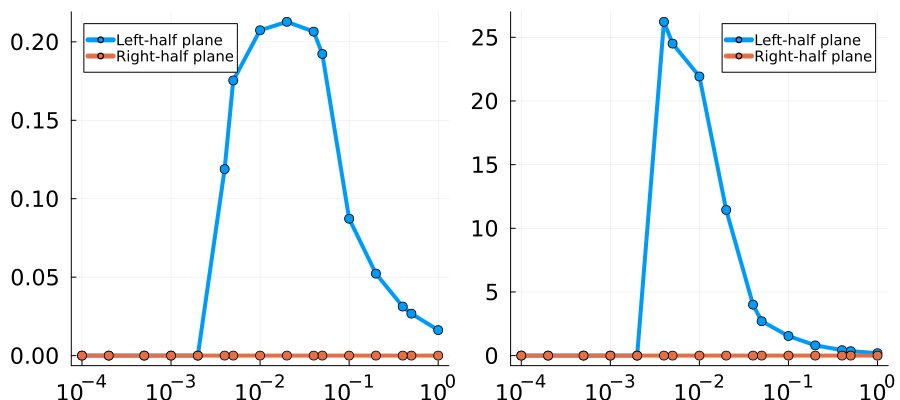

In [32]:
p_m1r=Plots.plot();
p_m1r=plot!(Delta_x.*(-1),vec(r_leftm1),lw=4,label="Left-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_m1r=plot!(Delta_x.*(-1),vec(r_rightm1),lw=4,label="Right-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_m1v=Plots.plot();
p_m1v=plot!(Delta_x.*(-1),vec(v_leftm1),lw=4,label="Left-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_m1v=plot!(Delta_x.*(-1),vec(v_rightm1),lw=4,label="Right-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
plot(p_m1r,p_m1v,size=(900,400))

In [33]:
t_m1=Table(Δx=Delta_x,ratio_left=vec(r_leftm1),mean_left=vec(v_leftm1),ratio_right=vec(r_rightm1),mean_right=vec(v_rightm1))

Table with 5 columns and 16 rows:
      Δx       ratio_left  mean_left  ratio_right  mean_right
    ┌────────────────────────────────────────────────────────
 1  │ -1.0     0.01625     0.187726   0.0          0.0
 2  │ -0.5     0.02675     0.347202   0.0          0.0
 3  │ -0.4     0.03125     0.427791   0.0          0.0
 4  │ -0.2     0.05225     0.804023   0.0          0.0
 5  │ -0.1     0.08725     1.53799    0.0          0.0
 6  │ -0.05    0.19225     2.70096    0.0          0.0
 7  │ -0.04    0.2065      4.00124    0.0          0.0
 8  │ -0.02    0.21275     11.4387    0.0          0.0
 9  │ -0.01    0.207375    21.9263    0.0          0.0
 10 │ -0.005   0.175375    24.5053    0.0          0.0
 11 │ -0.004   0.118875    26.2178    0.0          0.0
 12 │ -0.002   0.0         0.0        0.0          0.0
 13 │ -0.001   0.0         0.0        0.0          0.0
 14 │ -0.0005  0.0         0.0        0.0          0.0
 15 │ -0.0002  0.0         0.0        0.0          0.0
 16 │ -0.0001  0.

For $x=0$, we have

In [34]:
Delta_x=[-1,-0.5,-0.4,-0.2,-0.1,-0.05,-0.04,-0.02,-0.01,-0.005,-0.004,-0.002,-0.001,-0.0005,-0.0002,-0.0001];
r_left0=zeros(1,length(Delta_x));r_right0=zeros(1,length(Delta_x));
v_left0=zeros(1,length(Delta_x));v_right0=zeros(1,length(Delta_x));
α = [147/60,-6,45/6,-400/60,225/60,-72/60,1/6];β = [1,0,0,0,0,0,0];
C=A-0*B;
Eig=eigvals(Matrix(C));
for j=1:length(Delta_x)
    z_left=zeros(ComplexF64,0);z_right=zeros(ComplexF64,0);
    ξ_left=zeros(ComplexF64,0);ξ_right=zeros(ComplexF64,0);
    Δx=Delta_x[j]
    z=Δx*Eig;
    for i=1:length(z)
        ξ=compute_roots(α,β,z[i])
        if real(z[i])>0 && check_condition(ξ)==0
            append!(z_right,z[i])
            append!(ξ_right,ξ)
        end
        if real(z[i])<0 && check_condition(ξ)==0
            append!(z_left,z[i])
            append!(ξ_left,ξ)
        end
    end
    r_left0[j]=length(z_left)/M_s;
    r_right0[j]=length(z_right)/M_s;
    if length(ξ_left)==0
        v_left0[j]=0
    end
    if length(ξ_right)==0
        v_right0[j]=0
    end
    if length(ξ_left)>0
        ξ_restl=check_condition2(ξ_left)
        μ_left=abs.((abs.(ξ_restl).-1)./Δx)
        v_left0[j]=mean(μ_left)
    end
    if length(ξ_right)>0
        ξ_restr=check_condition2(ξ_right)
        μ_right=abs.((abs.(ξ_restr).-1)./Δx)
        v_right0[j]=mean(μ_right)
    end
end

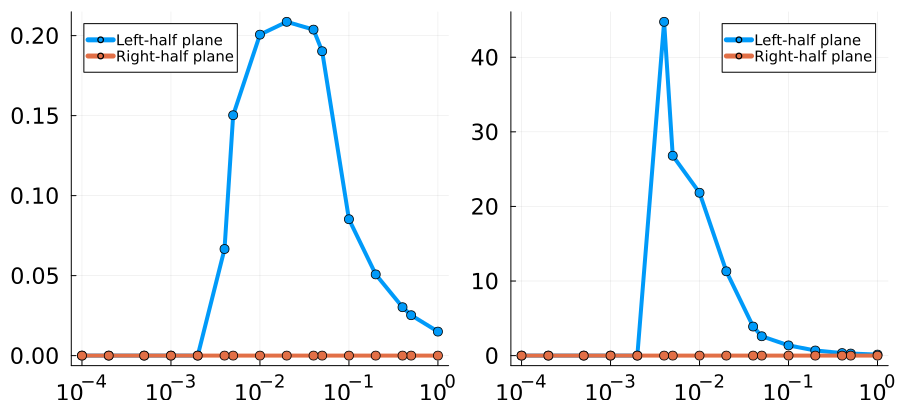

In [35]:
p_0r=Plots.plot();
p_0r=plot!(Delta_x.*(-1),vec(r_left0),lw=4,label="Left-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_0r=plot!(Delta_x.*(-1),vec(r_right0),lw=4,label="Right-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_0v=Plots.plot();
p_0v=plot!(Delta_x.*(-1),vec(v_left0),lw=4,label="Left-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_0v=plot!(Delta_x.*(-1),vec(v_right0),lw=4,label="Right-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
plot(p_0r,p_0v,size=(900,400))

In [36]:
t_0=Table(Δx=Delta_x,ratio_left=vec(r_left0),mean_left=vec(v_left0),ratio_right=vec(r_right0),mean_right=vec(v_right0))

Table with 5 columns and 16 rows:
      Δx       ratio_left  mean_left  ratio_right  mean_right
    ┌────────────────────────────────────────────────────────
 1  │ -1.0     0.015       0.136929   0.0          0.0
 2  │ -0.5     0.02525     0.275386   0.0          0.0
 3  │ -0.4     0.03025     0.340076   0.0          0.0
 4  │ -0.2     0.05075     0.68296    0.0          0.0
 5  │ -0.1     0.08525     1.36825    0.0          0.0
 6  │ -0.05    0.19025     2.5937     0.0          0.0
 7  │ -0.04    0.20375     3.89472    0.0          0.0
 8  │ -0.02    0.208625    11.3032    0.0          0.0
 9  │ -0.01    0.200625    21.8295    0.0          0.0
 10 │ -0.005   0.15025     26.797     0.0          0.0
 11 │ -0.004   0.066625    44.7487    0.0          0.0
 12 │ -0.002   0.0         0.0        0.0          0.0
 13 │ -0.001   0.0         0.0        0.0          0.0
 14 │ -0.0005  0.0         0.0        0.0          0.0
 15 │ -0.0002  0.0         0.0        0.0          0.0
 16 │ -0.0001  0.

For $x=1$, we have

In [37]:
Delta_x=[-1,-0.5,-0.4,-0.2,-0.1,-0.05,-0.04,-0.02,-0.01,-0.005,-0.004,-0.002,-0.001,-0.0005,-0.0002,-0.0001];
r_left1=zeros(1,length(Delta_x));r_right1=zeros(1,length(Delta_x));
v_left1=zeros(1,length(Delta_x));v_right1=zeros(1,length(Delta_x));
α = [147/60,-6,45/6,-400/60,225/60,-72/60,1/6];β = [1,0,0,0,0,0,0];
C=A+1*B;
Eig=eigvals(Matrix(C));
for j=1:length(Delta_x)
    z_left=zeros(ComplexF64,0);z_right=zeros(ComplexF64,0);
    ξ_left=zeros(ComplexF64,0);ξ_right=zeros(ComplexF64,0);
    Δx=Delta_x[j]
    z=Δx*Eig;
    for i=1:length(z)
        ξ=compute_roots(α,β,z[i])
        if real(z[i])>0 && check_condition(ξ)==0
            append!(z_right,z[i])
            append!(ξ_right,ξ)
        end
        if real(z[i])<0 && check_condition(ξ)==0
            append!(z_left,z[i])
            append!(ξ_left,ξ)
        end
    end
    r_left1[j]=length(z_left)/M_s;
    r_right1[j]=length(z_right)/M_s;
    if length(ξ_left)==0
        v_left1[j]=0
    end
    if length(ξ_right)==0
        v_right1[j]=0
    end
    if length(ξ_left)>0
        ξ_restl=check_condition2(ξ_left)
        μ_left=abs.((abs.(ξ_restl).-1)./Δx)
        v_left1[j]=mean(μ_left)
    end
    if length(ξ_right)>0
        ξ_restr=check_condition2(ξ_right)
        μ_right=abs.((abs.(ξ_restr).-1)./Δx)
        v_right1[j]=mean(μ_right)
    end
end

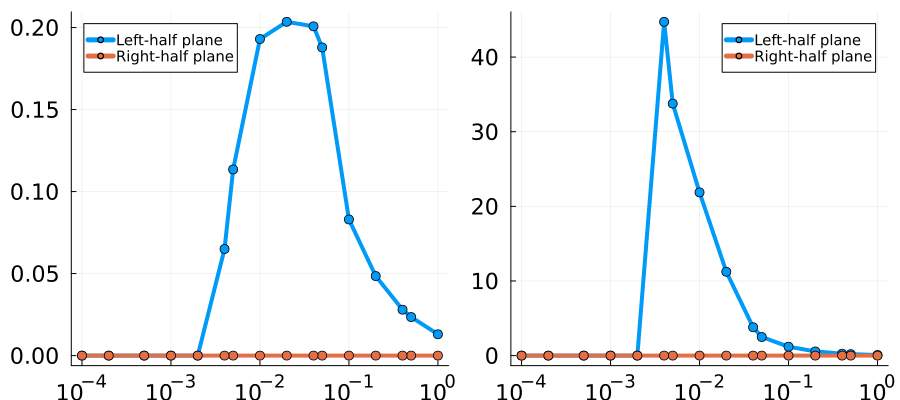

In [38]:
p_1r=Plots.plot();
p_1r=plot!(Delta_x.*(-1),vec(r_left1),lw=4,label="Left-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_1r=plot!(Delta_x.*(-1),vec(r_right1),lw=4,label="Right-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_1v=Plots.plot();
p_1v=plot!(Delta_x.*(-1),vec(v_left1),lw=4,label="Left-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_1v=plot!(Delta_x.*(-1),vec(v_right1),lw=4,label="Right-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
plot(p_1r,p_1v,size=(900,400))

In [39]:
t_1=Table(Δx=Delta_x,ratio_left=vec(r_left1),mean_left=vec(v_left1),ratio_right=vec(r_right1),mean_right=vec(v_right1))

Table with 5 columns and 16 rows:
      Δx       ratio_left  mean_left  ratio_right  mean_right
    ┌────────────────────────────────────────────────────────
 1  │ -1.0     0.013       0.0804954  0.0          0.0
 2  │ -0.5     0.0235      0.194612   0.0          0.0
 3  │ -0.4     0.028       0.255052   0.0          0.0
 4  │ -0.2     0.0485      0.56049    0.0          0.0
 5  │ -0.1     0.083       1.19125    0.0          0.0
 6  │ -0.05    0.187875    2.49496    0.0          0.0
 7  │ -0.04    0.20075     3.79693    0.0          0.0
 8  │ -0.02    0.2035      11.2323    0.0          0.0
 9  │ -0.01    0.193       21.8695    0.0          0.0
 10 │ -0.005   0.1135      33.7644    0.0          0.0
 11 │ -0.004   0.065       44.7274    0.0          0.0
 12 │ -0.002   0.0         0.0        0.0          0.0
 13 │ -0.001   0.0         0.0        0.0          0.0
 14 │ -0.0005  0.0         0.0        0.0          0.0
 15 │ -0.0002  0.0         0.0        0.0          0.0
 16 │ -0.0001  0.

For $x=2$, we have

In [40]:
Delta_x=[-1,-0.5,-0.4,-0.2,-0.1,-0.05,-0.04,-0.02,-0.01,-0.005,-0.004,-0.002,-0.001,-0.0005,-0.0002,-0.0001];
r_left2=zeros(1,length(Delta_x));r_right2=zeros(1,length(Delta_x));
v_left2=zeros(1,length(Delta_x));v_right2=zeros(1,length(Delta_x));
α = [147/60,-6,45/6,-400/60,225/60,-72/60,1/6];β = [1,0,0,0,0,0,0];
C=A+2*B;
Eig=eigvals(Matrix(C));
for j=1:length(Delta_x)
    z_left=zeros(ComplexF64,0);z_right=zeros(ComplexF64,0);
    ξ_left=zeros(ComplexF64,0);ξ_right=zeros(ComplexF64,0);
    Δx=Delta_x[j]
    z=Δx*Eig;
    for i=1:length(z)
        ξ=compute_roots(α,β,z[i])
        if real(z[i])>0 && check_condition(ξ)==0
            append!(z_right,z[i])
            append!(ξ_right,ξ)
        end
        if real(z[i])<0 && check_condition(ξ)==0
            append!(z_left,z[i])
            append!(ξ_left,ξ)
        end
    end
    r_left2[j]=length(z_left)/M_s;
    r_right2[j]=length(z_right)/M_s;
    if length(ξ_left)==0
        v_left2[j]=0
    end
    if length(ξ_right)==0
        v_right2[j]=0
    end
    if length(ξ_left)>0
        ξ_restl=check_condition2(ξ_left)
        μ_left=abs.((abs.(ξ_restl).-1)./Δx)
        v_left2[j]=mean(μ_left)
    end
    if length(ξ_right)>0
        ξ_restr=check_condition2(ξ_right)
        μ_right=abs.((abs.(ξ_restr).-1)./Δx)
        v_right2[j]=mean(μ_right)
    end
end

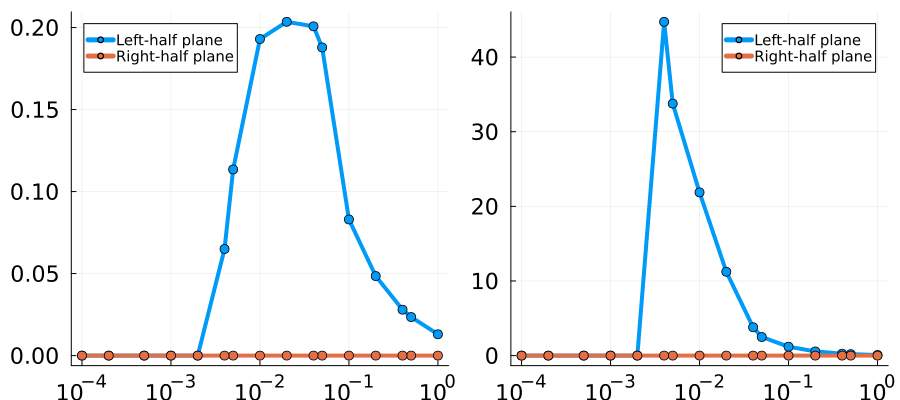

In [41]:
p_2r=Plots.plot();
p_2r=plot!(Delta_x.*(-1),vec(r_left1),lw=4,label="Left-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_2r=plot!(Delta_x.*(-1),vec(r_right1),lw=4,label="Right-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_2v=Plots.plot();
p_2v=plot!(Delta_x.*(-1),vec(v_left1),lw=4,label="Left-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_2v=plot!(Delta_x.*(-1),vec(v_right1),lw=4,label="Right-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
plot(p_2r,p_2v,size=(900,400))

In [42]:
t_2=Table(Δx=Delta_x,ratio_left=vec(r_left2),mean_left=vec(v_left2),ratio_right=vec(r_right2),mean_right=vec(v_right2))

Table with 5 columns and 16 rows:
      Δx       ratio_left  mean_left  ratio_right  mean_right
    ┌────────────────────────────────────────────────────────
 1  │ -1.0     0.009       0.0271778  0.0          0.0
 2  │ -0.5     0.02025     0.117663   0.0          0.0
 3  │ -0.4     0.02475     0.16903    0.0          0.0
 4  │ -0.2     0.04525     0.439376   0.0          0.0
 5  │ -0.1     0.0795      1.02197    0.0          0.0
 6  │ -0.05    0.1855      2.40182    0.0          0.0
 7  │ -0.04    0.197625    3.70848    0.0          0.0
 8  │ -0.02    0.19825     11.1856    0.0          0.0
 9  │ -0.01    0.184       22.1326    0.0          0.0
 10 │ -0.005   0.08        46.872     0.0          0.0
 11 │ -0.004   0.064375    43.9728    0.0          0.0
 12 │ -0.002   0.0         0.0        0.0          0.0
 13 │ -0.001   0.0         0.0        0.0          0.0
 14 │ -0.0005  0.0         0.0        0.0          0.0
 15 │ -0.0002  0.0         0.0        0.0          0.0
 16 │ -0.0001  0.

For $x=3$, we have

In [43]:
Delta_x=[-1,-0.5,-0.4,-0.2,-0.1,-0.05,-0.04,-0.02,-0.01,-0.005,-0.004,-0.002,-0.001,-0.0005,-0.0002,-0.0001];
r_left3=zeros(1,length(Delta_x));r_right3=zeros(1,length(Delta_x));
v_left3=zeros(1,length(Delta_x));v_right3=zeros(1,length(Delta_x));
α = [147/60,-6,45/6,-400/60,225/60,-72/60,1/6];β = [1,0,0,0,0,0,0];
C=A+3*B;
Eig=eigvals(Matrix(C));
for j=1:length(Delta_x)
    z_left=zeros(ComplexF64,0);z_right=zeros(ComplexF64,0);
    ξ_left=zeros(ComplexF64,0);ξ_right=zeros(ComplexF64,0);
    Δx=Delta_x[j]
    z=Δx*Eig;
    for i=1:length(z)
        ξ=compute_roots(α,β,z[i])
        if real(z[i])>0 && check_condition(ξ)==0
            append!(z_right,z[i])
            append!(ξ_right,ξ)
        end
        if real(z[i])<0 && check_condition(ξ)==0
            append!(z_left,z[i])
            append!(ξ_left,ξ)
        end
    end
    r_left3[j]=length(z_left)/M_s;
    r_right3[j]=length(z_right)/M_s;
    if length(ξ_left)==0
        v_left3[j]=0
    end
    if length(ξ_right)==0
        v_right3[j]=0
    end
    if length(ξ_left)>0
        ξ_restl=check_condition2(ξ_left)
        μ_left=abs.((abs.(ξ_restl).-1)./Δx)
        v_left3[j]=mean(μ_left)
    end
    if length(ξ_right)>0
        ξ_restr=check_condition2(ξ_right)
        μ_right=abs.((abs.(ξ_restr).-1)./Δx)
        v_right3[j]=mean(μ_right)
    end
end

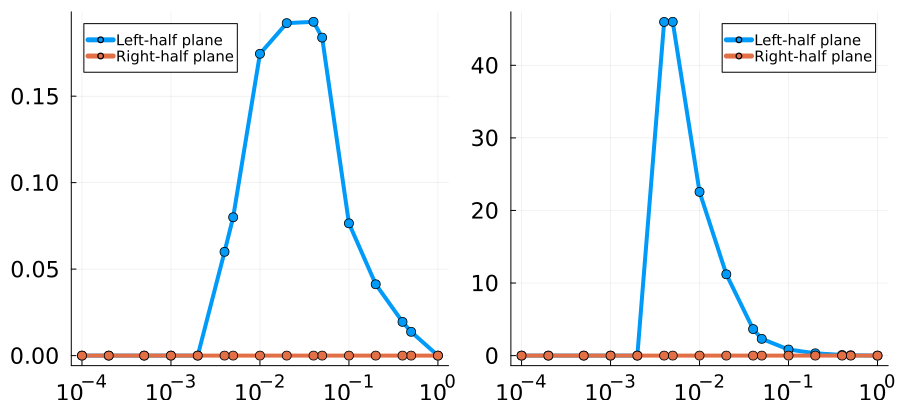

In [44]:
p_3r=Plots.plot();
p_3r=plot!(Delta_x.*(-1),vec(r_left3),lw=4,label="Left-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_3r=plot!(Delta_x.*(-1),vec(r_right3),lw=4,label="Right-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_3v=Plots.plot();
p_3v=plot!(Delta_x.*(-1),vec(v_left3),lw=4,label="Left-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_3v=plot!(Delta_x.*(-1),vec(v_right3),lw=4,label="Right-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
plot(p_3r,p_3v,size=(900,400))

In [45]:
t_3=Table(Δx=Delta_x,ratio_left=vec(r_left3),mean_left=vec(v_left3),ratio_right=vec(r_right3),mean_right=vec(v_right3))

Table with 5 columns and 16 rows:
      Δx       ratio_left  mean_left  ratio_right  mean_right
    ┌────────────────────────────────────────────────────────
 1  │ -1.0     0.0         0.0        0.0          0.0
 2  │ -0.5     0.01375     0.045527   0.0          0.0
 3  │ -0.4     0.0195      0.0849875  0.0          0.0
 4  │ -0.2     0.04125     0.316025   0.0          0.0
 5  │ -0.1     0.0765      0.838314   0.0          0.0
 6  │ -0.05    0.183875    2.30836    0.0          0.0
 7  │ -0.04    0.193       3.65756    0.0          0.0
 8  │ -0.02    0.19225     11.2056    0.0          0.0
 9  │ -0.01    0.1745      22.5583    0.0          0.0
 10 │ -0.005   0.08        45.9895    0.0          0.0
 11 │ -0.004   0.06        45.9744    0.0          0.0
 12 │ -0.002   0.0         0.0        0.0          0.0
 13 │ -0.001   0.0         0.0        0.0          0.0
 14 │ -0.0005  0.0         0.0        0.0          0.0
 15 │ -0.0002  0.0         0.0        0.0          0.0
 16 │ -0.0001  0.

For $x=4$, we have

In [46]:
Delta_x=[-1,-0.5,-0.4,-0.2,-0.1,-0.05,-0.04,-0.02,-0.01,-0.005,-0.004,-0.002,-0.001,-0.0005,-0.0002,-0.0001];
r_left4=zeros(1,length(Delta_x));r_right4=zeros(1,length(Delta_x));
v_left4=zeros(1,length(Delta_x));v_right4=zeros(1,length(Delta_x));
α = [147/60,-6,45/6,-400/60,225/60,-72/60,1/6];β = [1,0,0,0,0,0,0];
C=A+4*B;
Eig=eigvals(Matrix(C));
for j=1:length(Delta_x)
    z_left=zeros(ComplexF64,0);z_right=zeros(ComplexF64,0);
    ξ_left=zeros(ComplexF64,0);ξ_right=zeros(ComplexF64,0);
    Δx=Delta_x[j]
    z=Δx*Eig;
    for i=1:length(z)
        ξ=compute_roots(α,β,z[i])
        if real(z[i])>0 && check_condition(ξ)==0
            append!(z_right,z[i])
            append!(ξ_right,ξ)
        end
        if real(z[i])<0 && check_condition(ξ)==0
            append!(z_left,z[i])
            append!(ξ_left,ξ)
        end
    end
    r_left4[j]=length(z_left)/M_s;
    r_right4[j]=length(z_right)/M_s;
    if length(ξ_left)==0
        v_left4[j]=0
    end
    if length(ξ_right)==0
        v_right4[j]=0
    end
    if length(ξ_left)>0
        ξ_restl=check_condition2(ξ_left)
        μ_left=abs.((abs.(ξ_restl).-1)./Δx)
        v_left4[j]=mean(μ_left)
    end
    if length(ξ_right)>0
        ξ_restr=check_condition2(ξ_right)
        μ_right=abs.((abs.(ξ_restr).-1)./Δx)
        v_right4[j]=mean(μ_right)
    end
end

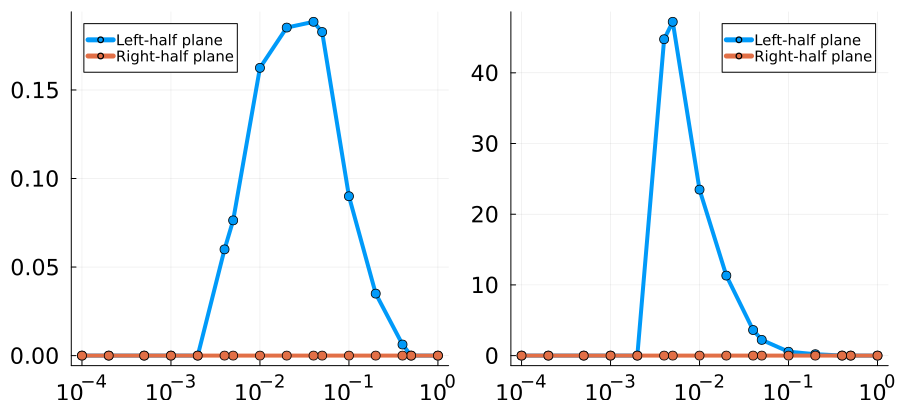

In [47]:
p_4r=Plots.plot();
p_4r=plot!(Delta_x.*(-1),vec(r_left4),lw=4,label="Left-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_4r=plot!(Delta_x.*(-1),vec(r_right4),lw=4,label="Right-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_4v=Plots.plot();
p_4v=plot!(Delta_x.*(-1),vec(v_left4),lw=4,label="Left-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_4v=plot!(Delta_x.*(-1),vec(v_right4),lw=4,label="Right-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
plot(p_4r,p_4v,size=(900,400))

In [48]:
t_4=Table(Δx=Delta_x,ratio_left=vec(r_left4),mean_left=vec(v_left4),ratio_right=vec(r_right4),mean_right=vec(v_right4))

Table with 5 columns and 16 rows:
      Δx       ratio_left  mean_left   ratio_right  mean_right
    ┌─────────────────────────────────────────────────────────
 1  │ -1.0     0.0         0.0         0.0          0.0
 2  │ -0.5     0.0         0.0         0.0          0.0
 3  │ -0.4     0.00625     0.00689582  0.0          0.0
 4  │ -0.2     0.035       0.198987    0.0          0.0
 5  │ -0.1     0.09        0.54677     0.0          0.0
 6  │ -0.05    0.18275     2.22225     0.0          0.0
 7  │ -0.04    0.1885      3.61825     0.0          0.0
 8  │ -0.02    0.18525     11.3188     0.0          0.0
 9  │ -0.01    0.1625      23.4806     0.0          0.0
 10 │ -0.005   0.076375    47.2126     0.0          0.0
 11 │ -0.004   0.06        44.7525     0.0          0.0
 12 │ -0.002   0.0         0.0         0.0          0.0
 13 │ -0.001   0.0         0.0         0.0          0.0
 14 │ -0.0005  0.0         0.0         0.0          0.0
 15 │ -0.0002  0.0         0.0         0.0          0.0


For $x=5$, we have

In [49]:
p_5=Plots.plot();
Delta_x=[-1,-0.5,-0.4,-0.2,-0.1,-0.05,-0.04,-0.02,-0.01,-0.005,-0.004,-0.002,-0.001,-0.0005,-0.0002,-0.0001];
r_left5=zeros(1,length(Delta_x));r_right5=zeros(1,length(Delta_x));
v_left5=zeros(1,length(Delta_x));v_right5=zeros(1,length(Delta_x));
α = [147/60,-6,45/6,-400/60,225/60,-72/60,1/6];β = [1,0,0,0,0,0,0];
C=A+5*B;
Eig=eigvals(Matrix(C));
for j=1:length(Delta_x)
    z_left=zeros(ComplexF64,0);z_right=zeros(ComplexF64,0);
    ξ_left=zeros(ComplexF64,0);ξ_right=zeros(ComplexF64,0);
    Δx=Delta_x[j]
    z=Δx*Eig;
    for i=1:length(z)
        ξ=compute_roots(α,β,z[i])
        if real(z[i])>0 && check_condition(ξ)==0
            append!(z_right,z[i])
            append!(ξ_right,ξ)
        end
        if real(z[i])<0 && check_condition(ξ)==0
            append!(z_left,z[i])
            append!(ξ_left,ξ)
        end
    end
    r_left5[j]=length(z_left)/M_s;
    r_right5[j]=length(z_right)/M_s;
    if length(ξ_left)==0
        v_left5[j]=0
    end
    if length(ξ_right)==0
        v_right5[j]=0
    end
    if length(ξ_left)>0
        ξ_restl=check_condition2(ξ_left)
        μ_left=abs.((abs.(ξ_restl).-1)./Δx)
        v_left5[j]=mean(μ_left)
    end
    if length(ξ_right)>0
        ξ_restr=check_condition2(ξ_right)
        μ_right=abs.((abs.(ξ_restr).-1)./Δx)
        v_right5[j]=mean(μ_right)
    end
end

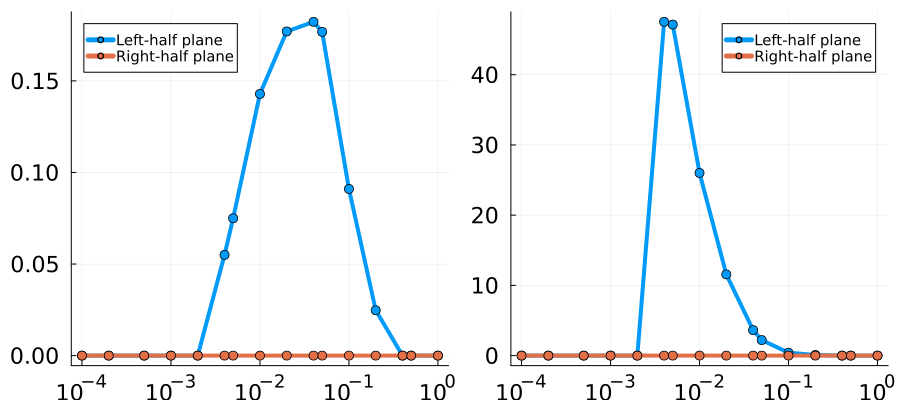

In [50]:
p_5r=Plots.plot();
p_5r=plot!(Delta_x.*(-1),vec(r_left5),lw=4,label="Left-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_5r=plot!(Delta_x.*(-1),vec(r_right5),lw=4,label="Right-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_5v=Plots.plot();
p_5v=plot!(Delta_x.*(-1),vec(v_left5),lw=4,label="Left-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_5v=plot!(Delta_x.*(-1),vec(v_right5),lw=4,label="Right-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
plot(p_5r,p_5v,size=(900,400))

In [51]:
t_5=Table(Δx=Delta_x,ratio_left=vec(r_left5),mean_left=vec(v_left5),ratio_right=vec(r_right5),mean_right=vec(v_right5))

Table with 5 columns and 16 rows:
      Δx       ratio_left  mean_left  ratio_right  mean_right
    ┌────────────────────────────────────────────────────────
 1  │ -1.0     0.0         0.0        0.0          0.0
 2  │ -0.5     0.0         0.0        0.0          0.0
 3  │ -0.4     0.0         0.0        0.0          0.0
 4  │ -0.2     0.02475     0.0866004  0.0          0.0
 5  │ -0.1     0.091       0.410905   0.0          0.0
 6  │ -0.05    0.17675     2.21106    0.0          0.0
 7  │ -0.04    0.18225     3.63096    0.0          0.0
 8  │ -0.02    0.177       11.5604    0.0          0.0
 9  │ -0.01    0.142875    26.0105    0.0          0.0
 10 │ -0.005   0.075       47.1435    0.0          0.0
 11 │ -0.004   0.055       47.5327    0.0          0.0
 12 │ -0.002   0.0         0.0        0.0          0.0
 13 │ -0.001   0.0         0.0        0.0          0.0
 14 │ -0.0005  0.0         0.0        0.0          0.0
 15 │ -0.0002  0.0         0.0        0.0          0.0
 16 │ -0.0001  0.

For $x=6$, we have

In [52]:
Delta_x=[-1,-0.5,-0.4,-0.2,-0.1,-0.05,-0.04,-0.02,-0.01,-0.005,-0.004,-0.002,-0.001,-0.0005,-0.0002,-0.0001];
r_left6=zeros(1,length(Delta_x));r_right6=zeros(1,length(Delta_x));
v_left6=zeros(1,length(Delta_x));v_right6=zeros(1,length(Delta_x));
α = [147/60,-6,45/6,-400/60,225/60,-72/60,1/6];β = [1,0,0,0,0,0,0];
C=A+6*B;
Eig=eigvals(Matrix(C));
for j=1:length(Delta_x)
    z_left=zeros(ComplexF64,0);z_right=zeros(ComplexF64,0);
    ξ_left=zeros(ComplexF64,0);ξ_right=zeros(ComplexF64,0);
    Δx=Delta_x[j]
    z=Δx*Eig;
    for i=1:length(z)
        ξ=compute_roots(α,β,z[i])
        if real(z[i])>0 && check_condition(ξ)==0
            append!(z_right,z[i])
            append!(ξ_right,ξ)
        end
        if real(z[i])<0 && check_condition(ξ)==0
            append!(z_left,z[i])
            append!(ξ_left,ξ)
        end
    end
    r_left6[j]=length(z_left)/M_s;
    r_right6[j]=length(z_right)/M_s;
    if length(ξ_left)==0
        v_left6[j]=0
    end
    if length(ξ_right)==0
        v_right6[j]=0
    end
    if length(ξ_left)>0
        ξ_restl=check_condition2(ξ_left)
        μ_left=abs.((abs.(ξ_restl).-1)./Δx)
        v_left6[j]=mean(μ_left)
    end
    if length(ξ_right)>0
        ξ_restr=check_condition2(ξ_right)
        μ_right=abs.((abs.(ξ_restr).-1)./Δx)
        v_right6[j]=mean(μ_right)
    end
end

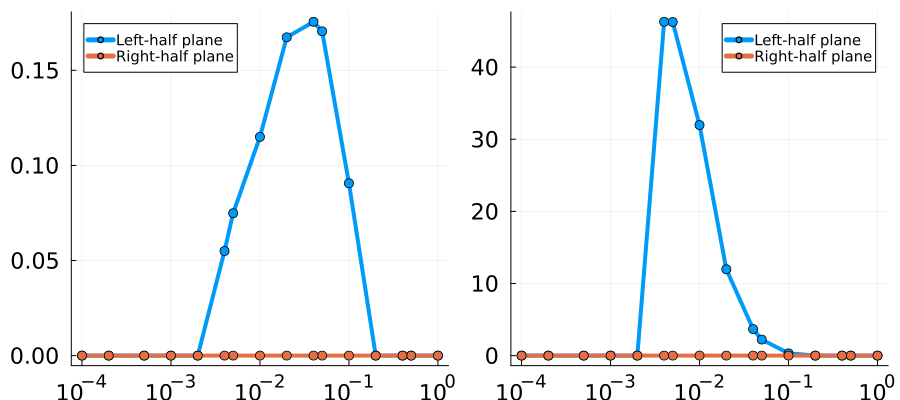

In [53]:
p_6r=Plots.plot();
p_6r=plot!(Delta_x.*(-1),vec(r_left6),lw=4,label="Left-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_6r=plot!(Delta_x.*(-1),vec(r_right6),lw=4,label="Right-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_6v=Plots.plot();
p_6v=plot!(Delta_x.*(-1),vec(v_left6),lw=4,label="Left-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_6v=plot!(Delta_x.*(-1),vec(v_right6),lw=4,label="Right-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
plot(p_6r,p_6v,size=(900,400))

In [54]:
t_6=Table(Δx=Delta_x,ratio_left=vec(r_left6),mean_left=vec(v_left6),ratio_right=vec(r_right6),mean_right=vec(v_right6))

Table with 5 columns and 16 rows:
      Δx       ratio_left  mean_left  ratio_right  mean_right
    ┌────────────────────────────────────────────────────────
 1  │ -1.0     0.0         0.0        0.0          0.0
 2  │ -0.5     0.0         0.0        0.0          0.0
 3  │ -0.4     0.0         0.0        0.0          0.0
 4  │ -0.2     0.0         0.0        0.0          0.0
 5  │ -0.1     0.090625    0.315848   0.0          0.0
 6  │ -0.05    0.1705      2.22315    0.0          0.0
 7  │ -0.04    0.1755      3.67867    0.0          0.0
 8  │ -0.02    0.167375    11.972     0.0          0.0
 9  │ -0.01    0.115       31.9674    0.0          0.0
 10 │ -0.005   0.074875    46.2519    0.0          0.0
 11 │ -0.004   0.055       46.2823    0.0          0.0
 12 │ -0.002   0.0         0.0        0.0          0.0
 13 │ -0.001   0.0         0.0        0.0          0.0
 14 │ -0.0005  0.0         0.0        0.0          0.0
 15 │ -0.0002  0.0         0.0        0.0          0.0
 16 │ -0.0001  0.

For $x=7$, we have

In [55]:
Delta_x=[-1,-0.5,-0.4,-0.2,-0.1,-0.05,-0.04,-0.02,-0.01,-0.005,-0.004,-0.002,-0.001,-0.0005,-0.0002,-0.0001];
r_left7=zeros(1,length(Delta_x));r_right7=zeros(1,length(Delta_x));
v_left7=zeros(1,length(Delta_x));v_right7=zeros(1,length(Delta_x));
α = [147/60,-6,45/6,-400/60,225/60,-72/60,1/6];β = [1,0,0,0,0,0,0];
C=A+7*B;
Eig=eigvals(Matrix(C));
for j=1:length(Delta_x)
    z_left=zeros(ComplexF64,0);z_right=zeros(ComplexF64,0);
    ξ_left=zeros(ComplexF64,0);ξ_right=zeros(ComplexF64,0);
    Δx=Delta_x[j]
    z=Δx*Eig;
    for i=1:length(z)
        ξ=compute_roots(α,β,z[i])
        if real(z[i])>0 && check_condition(ξ)==0
            append!(z_right,z[i])
            append!(ξ_right,ξ)
        end
        if real(z[i])<0 && check_condition(ξ)==0
            append!(z_left,z[i])
            append!(ξ_left,ξ)
        end
    end
    r_left7[j]=length(z_left)/M_s;
    r_right7[j]=length(z_right)/M_s;
    if length(ξ_left)==0
        v_left7[j]=0
    end
    if length(ξ_right)==0
        v_right7[j]=0
    end
    if length(ξ_left)>0
        ξ_restl=check_condition2(ξ_left)
        μ_left=abs.((abs.(ξ_restl).-1)./Δx)
        v_left7[j]=mean(μ_left)
    end
    if length(ξ_right)>0
        ξ_restr=check_condition2(ξ_right)
        μ_right=abs.((abs.(ξ_restr).-1)./Δx)
        v_right7[j]=mean(μ_right)
    end
end

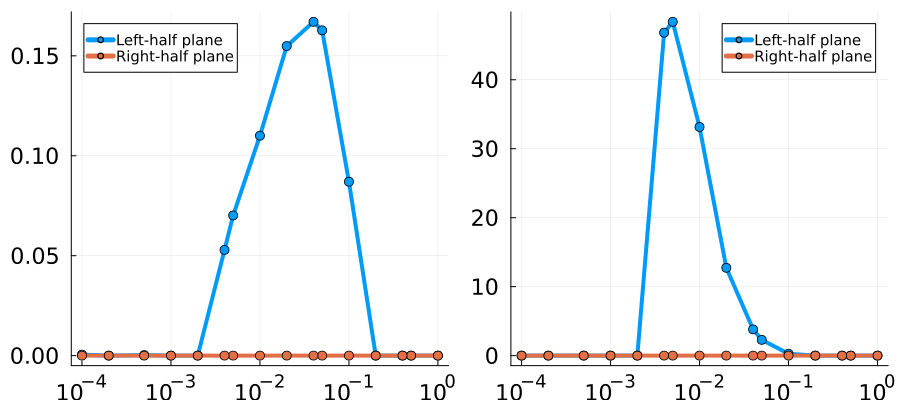

In [56]:
p_7r=Plots.plot();
p_7r=plot!(Delta_x.*(-1),vec(r_left7),lw=4,label="Left-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_7r=plot!(Delta_x.*(-1),vec(r_right7),lw=4,label="Right-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_7v=Plots.plot();
p_7v=plot!(Delta_x.*(-1),vec(v_left7),lw=4,label="Left-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_7v=plot!(Delta_x.*(-1),vec(v_right7),lw=4,label="Right-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
plot(p_7r,p_7v,size=(900,400))

In [57]:
t_7=Table(Δx=Delta_x,ratio_left=vec(r_left7),mean_left=vec(v_left7),ratio_right=vec(r_right7),mean_right=vec(v_right7))

Table with 5 columns and 16 rows:
      Δx       ratio_left  mean_left    ratio_right  mean_right
    ┌──────────────────────────────────────────────────────────
 1  │ -1.0     0.0         0.0          0.0          0.0
 2  │ -0.5     0.0         0.0          0.0          0.0
 3  │ -0.4     0.0         0.0          0.0          0.0
 4  │ -0.2     0.0         0.0          0.0          0.0
 5  │ -0.1     0.087       0.266804     0.0          0.0
 6  │ -0.05    0.16275     2.28255      0.0          0.0
 7  │ -0.04    0.167       3.79904      0.0          0.0
 8  │ -0.02    0.154875    12.7296      0.0          0.0
 9  │ -0.01    0.11        33.152       0.0          0.0
 10 │ -0.005   0.070125    48.3991      0.0          0.0
 11 │ -0.004   0.052875    46.8261      0.0          0.0
 12 │ -0.002   0.0         0.0          0.0          0.0
 13 │ -0.001   0.0         0.0          0.0          0.0
 14 │ -0.0005  0.00025     1.33227e-12  0.0          0.0
 15 │ -0.0002  0.0         0.0          

For $x=8$, we have

In [58]:
Delta_x=[-1,-0.5,-0.4,-0.2,-0.1,-0.05,-0.04,-0.02,-0.01,-0.005,-0.004,-0.002,-0.001,-0.0005,-0.0002,-0.0001];
r_left8=zeros(1,length(Delta_x));r_right8=zeros(1,length(Delta_x));
v_left8=zeros(1,length(Delta_x));v_right8=zeros(1,length(Delta_x));
α = [147/60,-6,45/6,-400/60,225/60,-72/60,1/6];β = [1,0,0,0,0,0,0];
C=A+8*B;
Eig=eigvals(Matrix(C));
for j=1:length(Delta_x)
    z_left=zeros(ComplexF64,0);z_right=zeros(ComplexF64,0);
    ξ_left=zeros(ComplexF64,0);ξ_right=zeros(ComplexF64,0);
    Δx=Delta_x[j]
    z=Δx*Eig;
    for i=1:length(z)
        ξ=compute_roots(α,β,z[i])
        if real(z[i])>0 && check_condition(ξ)==0
            append!(z_right,z[i])
            append!(ξ_right,ξ)
        end
        if real(z[i])<0 && check_condition(ξ)==0
            append!(z_left,z[i])
            append!(ξ_left,ξ)
        end
    end
    r_left8[j]=length(z_left)/M_s;
    r_right8[j]=length(z_right)/M_s;
    if length(ξ_left)==0
        v_left8[j]=0
    end
    if length(ξ_right)==0
        v_right8[j]=0
    end
    if length(ξ_left)>0
        ξ_restl=check_condition2(ξ_left)
        μ_left=abs.((abs.(ξ_restl).-1)./Δx)
        v_left8[j]=mean(μ_left)
    end
    if length(ξ_right)>0
        ξ_restr=check_condition2(ξ_right)
        μ_right=abs.((abs.(ξ_restr).-1)./Δx)
        v_right8[j]=mean(μ_right)
    end
end

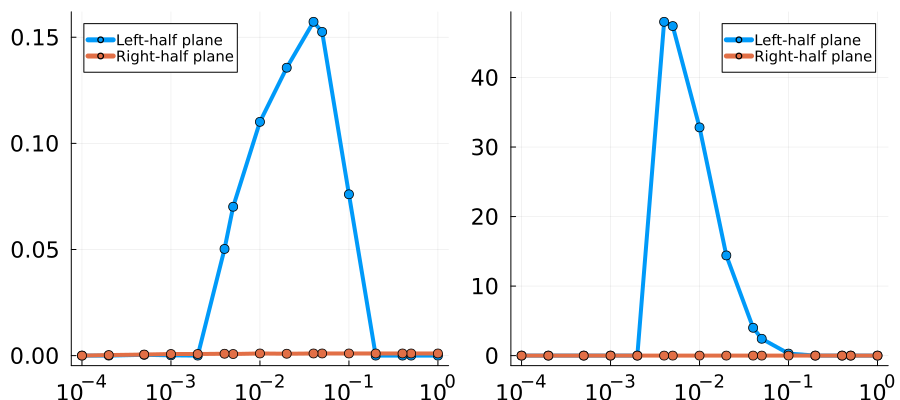

In [59]:
p_8r=Plots.plot();
p_8r=plot!(Delta_x.*(-1),vec(r_left8),lw=4,label="Left-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_8r=plot!(Delta_x.*(-1),vec(r_right8),lw=4,label="Right-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_8v=Plots.plot();
p_8v=plot!(Delta_x.*(-1),vec(v_left8),lw=4,label="Left-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_8v=plot!(Delta_x.*(-1),vec(v_right8),lw=4,label="Right-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
plot(p_8r,p_8v,size=(900,400))

In [60]:
t_8=Table(Δx=Delta_x,ratio_left=vec(r_left8),mean_left=vec(v_left8),ratio_right=vec(r_right8),mean_right=vec(v_right8))

Table with 5 columns and 16 rows:
      Δx       ratio_left  mean_left    ratio_right  mean_right
    ┌───────────────────────────────────────────────────────────
 1  │ -1.0     0.0         0.0          0.001        5.66547e-13
 2  │ -0.5     0.0         0.0          0.001        5.67435e-13
 3  │ -0.4     0.0         0.0          0.001        5.66353e-13
 4  │ -0.2     0.0         0.0          0.001        5.61495e-13
 5  │ -0.1     0.076       0.290705     0.001        5.67046e-13
 6  │ -0.05    0.1525      2.41906      0.001        5.83977e-13
 7  │ -0.04    0.15725     4.00072      0.001        5.82173e-13
 8  │ -0.02    0.135625    14.4091      0.000875     5.85246e-13
 9  │ -0.01    0.110125    32.8251      0.001        6.82787e-13
 10 │ -0.005   0.070125    47.3985      0.00075      7.69755e-13
 11 │ -0.004   0.05025     48.0081      0.000875     1.05471e-12
 12 │ -0.002   0.0         0.0          0.00075      2.38698e-12
 13 │ -0.001   0.000125    6.66134e-13  0.00075      3.70

For $x=9$, we have

In [61]:
Delta_x=[-1,-0.5,-0.4,-0.2,-0.1,-0.05,-0.04,-0.02,-0.01,-0.005,-0.004,-0.002,-0.001,-0.0005,-0.0002,-0.0001];
r_left9=zeros(1,length(Delta_x));r_right9=zeros(1,length(Delta_x));
v_left9=zeros(1,length(Delta_x));v_right9=zeros(1,length(Delta_x));
α = [147/60,-6,45/6,-400/60,225/60,-72/60,1/6];β = [1,0,0,0,0,0,0];
C=A+9*B;
Eig=eigvals(Matrix(C));
for j=1:length(Delta_x)
    z_left=zeros(ComplexF64,0);z_right=zeros(ComplexF64,0);
    ξ_left=zeros(ComplexF64,0);ξ_right=zeros(ComplexF64,0);
    Δx=Delta_x[j]
    z=Δx*Eig;
    for i=1:length(z)
        ξ=compute_roots(α,β,z[i])
        if real(z[i])>0 && check_condition(ξ)==0
            append!(z_right,z[i])
            append!(ξ_right,ξ)
        end
        if real(z[i])<0 && check_condition(ξ)==0
            append!(z_left,z[i])
            append!(ξ_left,ξ)
        end
    end
    r_left9[j]=length(z_left)/M_s;
    r_right9[j]=length(z_right)/M_s;
    if length(ξ_left)==0
        v_left9[j]=0
    end
    if length(ξ_right)==0
        v_right9[j]=0
    end
    if length(ξ_left)>0
        ξ_restl=check_condition2(ξ_left)
        μ_left=abs.((abs.(ξ_restl).-1)./Δx)
        v_left9[j]=mean(μ_left)
    end
    if length(ξ_right)>0
        ξ_restr=check_condition2(ξ_right)
        μ_right=abs.((abs.(ξ_restr).-1)./Δx)
        v_right9[j]=mean(μ_right)
    end
end

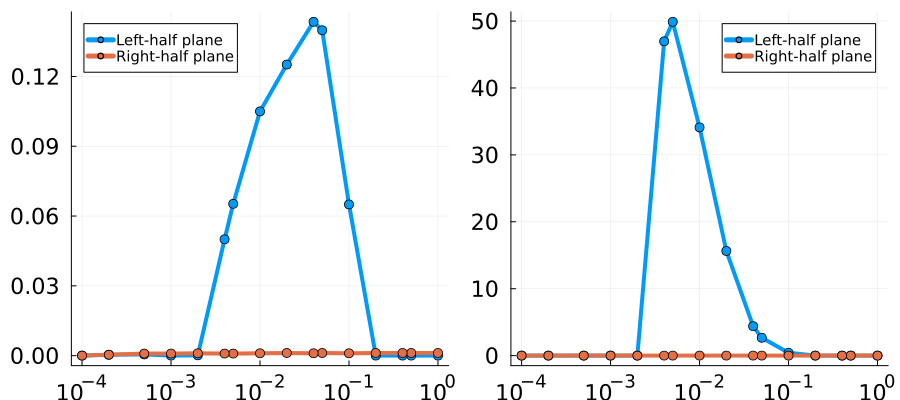

In [62]:
p_9r=Plots.plot();
p_9r=plot!(Delta_x.*(-1),vec(r_left9),lw=4,label="Left-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_9r=plot!(Delta_x.*(-1),vec(r_right9),lw=4,label="Right-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_9v=Plots.plot();
p_9v=plot!(Delta_x.*(-1),vec(v_left9),lw=4,label="Left-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_9v=plot!(Delta_x.*(-1),vec(v_right9),lw=4,label="Right-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
plot(p_9r,p_9v,size=(900,400))

In [63]:
t_9=Table(Δx=Delta_x,ratio_left=vec(r_left9),mean_left=vec(v_left9),ratio_right=vec(r_right9),mean_right=vec(v_right9))

Table with 5 columns and 16 rows:
      Δx       ratio_left  mean_left    ratio_right  mean_right
    ┌───────────────────────────────────────────────────────────
 1  │ -1.0     0.0         0.0          0.001125     6.73955e-13
 2  │ -0.5     0.0         0.0          0.001125     6.73782e-13
 3  │ -0.4     0.0         0.0          0.001125     6.73659e-13
 4  │ -0.2     0.0         0.0          0.001125     6.72178e-13
 5  │ -0.1     0.065       0.422195     0.001        7.38021e-13
 6  │ -0.05    0.139875    2.66307      0.001125     6.89819e-13
 7  │ -0.04    0.1435      4.39939      0.001        8.14626e-13
 8  │ -0.02    0.125125    15.6404      0.001125     6.9574e-13
 9  │ -0.01    0.105       34.1121      0.001        7.85483e-13
 10 │ -0.005   0.06525     49.8875      0.000875     7.54952e-13
 11 │ -0.004   0.05        46.9734      0.000875     8.08877e-13
 12 │ -0.002   0.000125    1.11022e-13  0.001        1.45717e-12
 13 │ -0.001   0.0         0.0          0.000875     5.107

For $x=10$, we have

In [64]:
Delta_x=[-1,-0.5,-0.4,-0.2,-0.1,-0.05,-0.04,-0.02,-0.01,-0.005,-0.004,-0.002,-0.001,-0.0005,-0.0002,-0.0001];
r_left10=zeros(1,length(Delta_x));r_right10=zeros(1,length(Delta_x));
v_left10=zeros(1,length(Delta_x));v_right10=zeros(1,length(Delta_x));
α = [147/60,-6,45/6,-400/60,225/60,-72/60,1/6];β = [1,0,0,0,0,0,0];
C=A+10*B;
Eig=eigvals(Matrix(C));
for j=1:length(Delta_x)
    z_left=zeros(ComplexF64,0);z_right=zeros(ComplexF64,0);
    ξ_left=zeros(ComplexF64,0);ξ_right=zeros(ComplexF64,0);
    Δx=Delta_x[j]
    z=Δx*Eig;
    for i=1:length(z)
        ξ=compute_roots(α,β,z[i])
        if real(z[i])>0 && check_condition(ξ)==0
            append!(z_right,z[i])
            append!(ξ_right,ξ)
        end
        if real(z[i])<0 && check_condition(ξ)==0
            append!(z_left,z[i])
            append!(ξ_left,ξ)
        end
    end
    r_left10[j]=length(z_left)/M_s;
    r_right10[j]=length(z_right)/M_s;
    if length(ξ_left)==0
        v_left10[j]=0
    end
    if length(ξ_right)==0
        v_right10[j]=0
    end
    if length(ξ_left)>0
        ξ_restl=check_condition2(ξ_left)
        μ_left=abs.((abs.(ξ_restl).-1)./Δx)
        v_left10[j]=mean(μ_left)
    end
    if length(ξ_right)>0
        ξ_restr=check_condition2(ξ_right)
        μ_right=abs.((abs.(ξ_restr).-1)./Δx)
        v_right10[j]=mean(μ_right)
    end
end

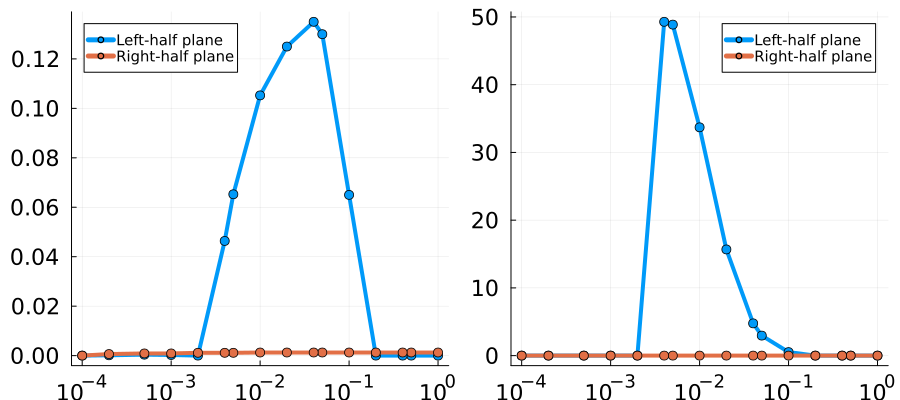

In [65]:
p_10r=Plots.plot();
p_10r=plot!(Delta_x.*(-1),vec(r_left10),lw=4,label="Left-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_10r=plot!(Delta_x.*(-1),vec(r_right10),lw=4,label="Right-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_10v=Plots.plot();
p_10v=plot!(Delta_x.*(-1),vec(v_left10),lw=4,label="Left-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_10v=plot!(Delta_x.*(-1),vec(v_right10),lw=4,label="Right-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
plot(p_10r,p_10v,size=(900,400))

In [66]:
t_10=Table(Δx=Delta_x,ratio_left=vec(r_left10),mean_left=vec(v_left10),ratio_right=vec(r_right10),mean_right=vec(v_right10))

Table with 5 columns and 16 rows:
      Δx       ratio_left  mean_left    ratio_right  mean_right
    ┌───────────────────────────────────────────────────────────
 1  │ -1.0     0.0         0.0          0.00125      6.96088e-13
 2  │ -0.5     0.0         0.0          0.00125      6.94333e-13
 3  │ -0.4     0.0         0.0          0.00125      6.93778e-13
 4  │ -0.2     0.0         0.0          0.00125      6.97442e-13
 5  │ -0.1     0.065       0.51638      0.00125      7.00107e-13
 6  │ -0.05    0.13        2.95146      0.00125      6.8745e-13
 7  │ -0.04    0.135       4.75962      0.00125      6.79456e-13
 8  │ -0.02    0.125       15.6751      0.00125      6.72795e-13
 9  │ -0.01    0.10525     33.7037      0.00125      7.50511e-13
 10 │ -0.005   0.06525     48.8682      0.001125     7.50017e-13
 11 │ -0.004   0.046375    49.2797      0.001125     9.56025e-13
 12 │ -0.002   0.0         0.0          0.001125     1.75169e-12
 13 │ -0.001   0.00025     6.66134e-13  0.000875     4.916

For $x=11$, we have

In [67]:
Delta_x=[-1,-0.5,-0.4,-0.2,-0.1,-0.05,-0.04,-0.02,-0.01,-0.005,-0.004,-0.002,-0.001,-0.0005,-0.0002,-0.0001];
r_left11=zeros(1,length(Delta_x));r_right11=zeros(1,length(Delta_x));
v_left11=zeros(1,length(Delta_x));v_right11=zeros(1,length(Delta_x));
α = [147/60,-6,45/6,-400/60,225/60,-72/60,1/6];β = [1,0,0,0,0,0,0];
C=A+11*B;
Eig=eigvals(Matrix(C));
for j=1:length(Delta_x)
    z_left=zeros(ComplexF64,0);z_right=zeros(ComplexF64,0);
    ξ_left=zeros(ComplexF64,0);ξ_right=zeros(ComplexF64,0);
    Δx=Delta_x[j]
    z=Δx*Eig;
    for i=1:length(z)
        ξ=compute_roots(α,β,z[i])
        if real(z[i])>0 && check_condition(ξ)==0
            append!(z_right,z[i])
            append!(ξ_right,ξ)
        end
        if real(z[i])<0 && check_condition(ξ)==0
            append!(z_left,z[i])
            append!(ξ_left,ξ)
        end
    end
    r_left11[j]=length(z_left)/M_s;
    r_right11[j]=length(z_right)/M_s;
    if length(ξ_left)==0
        v_left11[j]=0
    end
    if length(ξ_right)==0
        v_right11[j]=0
    end
    if length(ξ_left)>0
        ξ_restl=check_condition2(ξ_left)
        μ_left=abs.((abs.(ξ_restl).-1)./Δx)
        v_left11[j]=mean(μ_left)
    end
    if length(ξ_right)>0
        ξ_restr=check_condition2(ξ_right)
        μ_right=abs.((abs.(ξ_restr).-1)./Δx)
        v_right11[j]=mean(μ_right)
    end
end

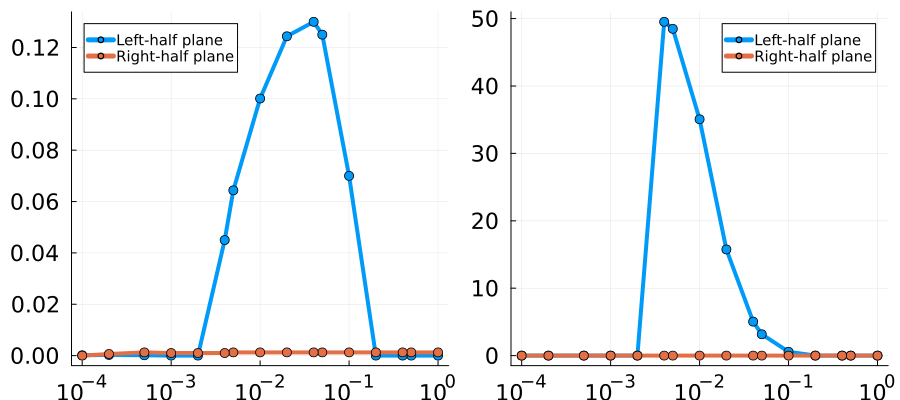

In [68]:
p_11r=Plots.plot();
p_11r=plot!(Delta_x.*(-1),vec(r_left11),lw=4,label="Left-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_11r=plot!(Delta_x.*(-1),vec(r_right11),lw=4,label="Right-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_11v=Plots.plot();
p_11v=plot!(Delta_x.*(-1),vec(v_left11),lw=4,label="Left-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_11v=plot!(Delta_x.*(-1),vec(v_right11),lw=4,label="Right-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
plot(p_11r,p_11v,size=(900,400))

In [69]:
t_11=Table(Δx=Delta_x,ratio_left=vec(r_left11),mean_left=vec(v_left11),ratio_right=vec(r_right11),mean_right=vec(v_right11))

Table with 5 columns and 16 rows:
      Δx       ratio_left  mean_left    ratio_right  mean_right
    ┌───────────────────────────────────────────────────────────
 1  │ -1.0     0.0         0.0          0.00125      7.17337e-13
 2  │ -0.5     0.0         0.0          0.00125      7.16405e-13
 3  │ -0.4     0.0         0.0          0.00125      7.17759e-13
 4  │ -0.2     0.0         0.0          0.00125      7.18425e-13
 5  │ -0.1     0.07        0.566181     0.00125      7.2764e-13
 6  │ -0.05    0.125       3.16464      0.00125      7.21645e-13
 7  │ -0.04    0.13        5.03571      0.00125      7.03881e-13
 8  │ -0.02    0.124375    15.75        0.00125      7.11653e-13
 9  │ -0.01    0.100125    35.0679      0.00125      7.79377e-13
 10 │ -0.005   0.064375    48.4798      0.00125      8.9706e-13
 11 │ -0.004   0.045       49.5215      0.001        1.1588e-12
 12 │ -0.002   0.0         0.0          0.001        1.73472e-12
 13 │ -0.001   0.0         0.0          0.001        4.2466e

For $x=12$, we have

In [70]:
Delta_x=[-1,-0.5,-0.4,-0.2,-0.1,-0.05,-0.04,-0.02,-0.01,-0.005,-0.004,-0.002,-0.001,-0.0005,-0.0002,-0.0001];
r_left12=zeros(1,length(Delta_x));r_right12=zeros(1,length(Delta_x));
v_left12=zeros(1,length(Delta_x));v_right12=zeros(1,length(Delta_x));
α = [147/60,-6,45/6,-400/60,225/60,-72/60,1/6];β = [1,0,0,0,0,0,0];
C=A+12*B;
Eig=eigvals(Matrix(C));
for j=1:length(Delta_x)
    z_left=zeros(ComplexF64,0);z_right=zeros(ComplexF64,0);
    ξ_left=zeros(ComplexF64,0);ξ_right=zeros(ComplexF64,0);
    Δx=Delta_x[j]
    z=Δx*Eig;
    for i=1:length(z)
        ξ=compute_roots(α,β,z[i])
        if real(z[i])>0 && check_condition(ξ)==0
            append!(z_right,z[i])
            append!(ξ_right,ξ)
        end
        if real(z[i])<0 && check_condition(ξ)==0
            append!(z_left,z[i])
            append!(ξ_left,ξ)
        end
    end
    r_left12[j]=length(z_left)/M_s;
    r_right12[j]=length(z_right)/M_s;
    if length(ξ_left)==0
        v_left12[j]=0
    end
    if length(ξ_right)==0
        v_right12[j]=0
    end
    if length(ξ_left)>0
        ξ_restl=check_condition2(ξ_left)
        μ_left=abs.((abs.(ξ_restl).-1)./Δx)
        v_left12[j]=mean(μ_left)
    end
    if length(ξ_right)>0
        ξ_restr=check_condition2(ξ_right)
        μ_right=abs.((abs.(ξ_restr).-1)./Δx)
        v_right12[j]=mean(μ_right)
    end
end

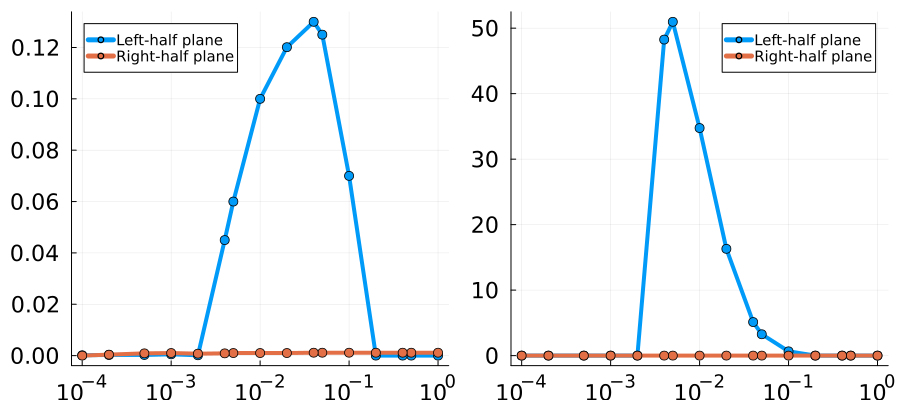

In [71]:
p_12r=Plots.plot();
p_12r=plot!(Delta_x.*(-1),vec(r_left12),lw=4,label="Left-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_12r=plot!(Delta_x.*(-1),vec(r_right12),lw=4,label="Right-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_12v=Plots.plot();
p_12v=plot!(Delta_x.*(-1),vec(v_left12),lw=4,label="Left-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_12v=plot!(Delta_x.*(-1),vec(v_right12),lw=4,label="Right-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
plot(p_12r,p_12v,size=(900,400))

In [72]:
t_12=Table(Δx=Delta_x,ratio_left=vec(r_left12),mean_left=vec(v_left12),ratio_right=vec(r_right12),mean_right=vec(v_right12))

Table with 5 columns and 16 rows:
      Δx       ratio_left  mean_left    ratio_right  mean_right
    ┌───────────────────────────────────────────────────────────
 1  │ -1.0     0.0         0.0          0.001125     6.96727e-13
 2  │ -0.5     0.0         0.0          0.001125     6.97812e-13
 3  │ -0.4     0.0         0.0          0.001125     6.99626e-13
 4  │ -0.2     0.0         0.0          0.001125     6.93026e-13
 5  │ -0.1     0.07        0.652996     0.001125     6.99934e-13
 6  │ -0.05    0.125       3.25817      0.001125     7.12023e-13
 7  │ -0.04    0.13        5.12135      0.001125     6.86488e-13
 8  │ -0.02    0.120125    16.3019      0.001        7.52176e-13
 9  │ -0.01    0.1         34.7506      0.001        7.35523e-13
 10 │ -0.005   0.06        50.9684      0.001        1.08802e-12
 11 │ -0.004   0.045       48.2572      0.000875     1.27676e-12
 12 │ -0.002   0.000125    4.44089e-13  0.00075      2.42399e-12
 13 │ -0.001   0.0005      1.9984e-12   0.001        3.52

For $x=13$, we have

In [73]:
Delta_x=[-1,-0.5,-0.4,-0.2,-0.1,-0.05,-0.04,-0.02,-0.01,-0.005,-0.004,-0.002,-0.001,-0.0005,-0.0002,-0.0001];
r_left13=zeros(1,length(Delta_x));r_right13=zeros(1,length(Delta_x));
v_left13=zeros(1,length(Delta_x));v_right13=zeros(1,length(Delta_x));
α = [147/60,-6,45/6,-400/60,225/60,-72/60,1/6];β = [1,0,0,0,0,0,0];
C=A+13*B;
Eig=eigvals(Matrix(C));
for j=1:length(Delta_x)
    z_left=zeros(ComplexF64,0);z_right=zeros(ComplexF64,0);
    ξ_left=zeros(ComplexF64,0);ξ_right=zeros(ComplexF64,0);
    Δx=Delta_x[j]
    z=Δx*Eig;
    for i=1:length(z)
        ξ=compute_roots(α,β,z[i])
        if real(z[i])>0 && check_condition(ξ)==0
            append!(z_right,z[i])
            append!(ξ_right,ξ)
        end
        if real(z[i])<0 && check_condition(ξ)==0
            append!(z_left,z[i])
            append!(ξ_left,ξ)
        end
    end
    r_left13[j]=length(z_left)/M_s;
    r_right13[j]=length(z_right)/M_s;
    if length(ξ_left)==0
        v_left13[j]=0
    end
    if length(ξ_right)==0
        v_right13[j]=0
    end
    if length(ξ_left)>0
        ξ_restl=check_condition2(ξ_left)
        μ_left=abs.((abs.(ξ_restl).-1)./Δx)
        v_left13[j]=mean(μ_left)
    end
    if length(ξ_right)>0
        ξ_restr=check_condition2(ξ_right)
        μ_right=abs.((abs.(ξ_restr).-1)./Δx)
        v_right13[j]=mean(μ_right)
    end
end

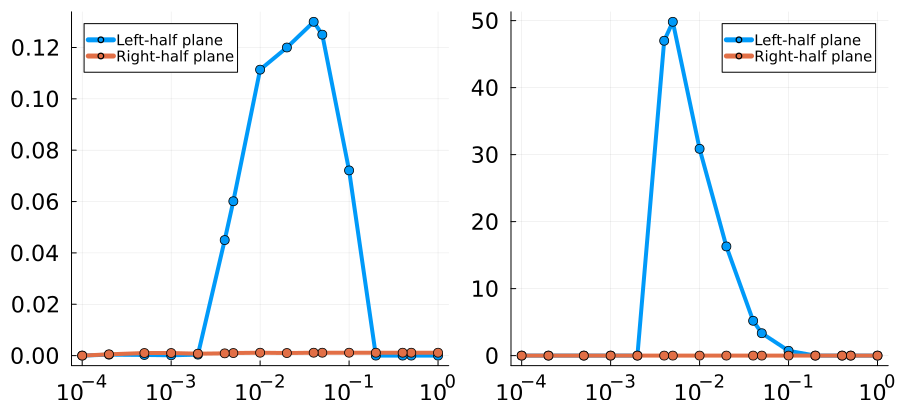

In [74]:
p_13r=Plots.plot();
p_13r=plot!(Delta_x.*(-1),vec(r_left13),lw=4,label="Left-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_13r=plot!(Delta_x.*(-1),vec(r_right13),lw=4,label="Right-half plane",legend=:topleft,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_13v=Plots.plot();
p_13v=plot!(Delta_x.*(-1),vec(v_left13),lw=4,label="Left-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
p_13v=plot!(Delta_x.*(-1),vec(v_right13),lw=4,label="Right-half plane",legend=:topright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log);
plot(p_13r,p_13v,size=(900,400))

In [75]:
t_13=Table(Δx=Delta_x,ratio_left=vec(r_left13),mean_left=vec(v_left13),ratio_right=vec(r_right13),mean_right=vec(v_right13))

Table with 5 columns and 16 rows:
      Δx       ratio_left  mean_left    ratio_right  mean_right
    ┌───────────────────────────────────────────────────────────
 1  │ -1.0     0.0         0.0          0.001125     9.01353e-13
 2  │ -0.5     0.0         0.0          0.001125     8.98294e-13
 3  │ -0.4     0.0         0.0          0.001125     9.0329e-13
 4  │ -0.2     0.0         0.0          0.001125     8.99774e-13
 5  │ -0.1     0.072125    0.714964     0.001125     9.01501e-13
 6  │ -0.05    0.125       3.3425       0.001125     9.17291e-13
 7  │ -0.04    0.13        5.19513      0.001125     8.87562e-13
 8  │ -0.02    0.12        16.2936      0.001        9.24261e-13
 9  │ -0.01    0.111375    30.8664      0.001125     8.16631e-13
 10 │ -0.005   0.060125    49.8193      0.001        1.18239e-12
 11 │ -0.004   0.045       46.9958      0.000875     8.72318e-13
 12 │ -0.002   0.000375    5.18104e-13  0.00075      1.42479e-12
 13 │ -0.001   0.000125    1.33227e-12  0.001        4.024

To determine the overall influence of the problematic eigenvalues, we combine the above results.

In [76]:
p_c=Plots.plot();
r_left=((r_leftm10+r_leftm9+r_leftm8+r_leftm7+r_leftm6+r_leftm5+r_leftm4+r_leftm3+r_leftm2+r_leftm1+r_left0+r_left1+r_left2
        +r_left3+r_left4+r_left5+r_left6+r_left7+r_left8+r_left9+r_left10+r_left11+r_left12+r_left13)*M_s) ./ (M_s*24);
r_right=((r_rightm10+r_rightm9+r_rightm8+r_rightm7+r_rightm6+r_rightm5+r_rightm4+r_rightm3+r_rightm2+r_rightm1+r_right0+r_right1
        +r_right2+r_right3+r_right4+r_right5+r_right6+r_right7+r_right8+r_right9+r_right10+r_right11
        +r_right12+r_right13)*M_s) ./ (M_s*24);
v_left=(v_leftm10+v_leftm9+v_leftm8+v_leftm7+v_leftm6+v_leftm5+v_leftm4+v_leftm3+v_leftm2+v_leftm1+v_left0+v_left1+v_left2
        +v_left3+v_left4+v_left5+v_left6+v_left7+v_left8+v_left9+v_left10+v_left11+v_left12+v_left13) ./ 24;
v_right=(v_rightm10+v_rightm9+v_rightm8+v_rightm7+v_rightm6+v_rightm5+v_rightm4+v_rightm3+v_rightm2+v_rightm1+v_right0+v_right1
        +v_right2+v_right3+v_right4+v_right5+v_right6+v_right7+v_right8+v_right9+v_right10+v_right11+v_right12+v_right13) ./ 24;
for i=1:length(r_left)
    if r_left[i]==0
        r_left[i]=10^(-16)
    end
    if r_right[i]==0
        r_right[i]=10^(-16)
    end
    if v_left[i]==0
        v_left[i]=10^(-16)
    end
    if v_right[i]==0
        v_right[i]=10^(-16)
    end
end

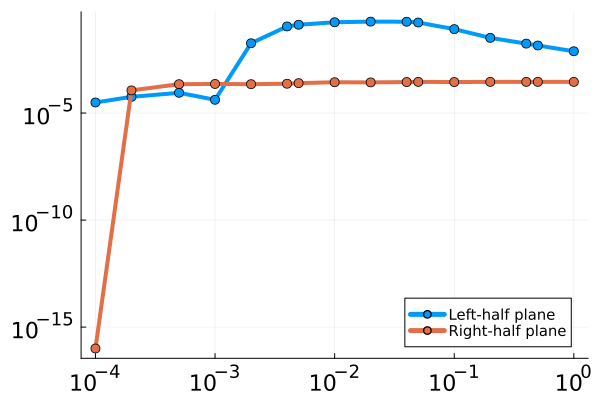

In [80]:
p_r=Plots.plot();
p_r=plot!(Delta_x.*(-1),vec(r_left),lw=4,label="Left-half plane",legend=:bottomright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log,yaxis=:log);
p_r=plot!(Delta_x.*(-1),vec(r_right),lw=4,label="Right-half plane",legend=:bottomright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log,yaxis=:log)

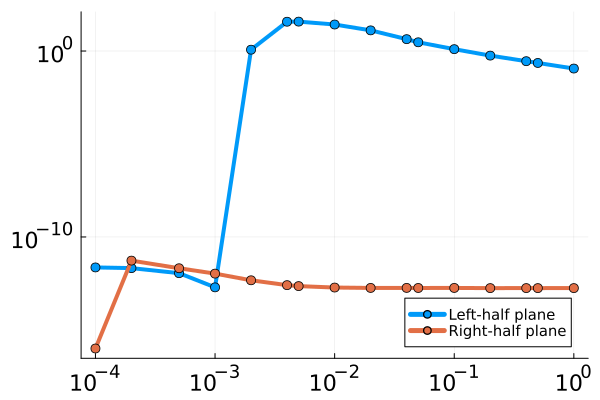

In [81]:
p_v=Plots.plot();
p_v=plot!(Delta_x.*(-1),vec(v_left),lw=4,label="Left-half plane",legend=:bottomright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log,yaxis=:log);
p_v=plot!(Delta_x.*(-1),vec(v_right),lw=4,label="Right-half plane",legend=:bottomright,marker=(:circle,5),xtickfontsize=15,
    ytickfontsize=15,legendfontsize=10,xaxis=:log,yaxis=:log)

In [84]:
β=2;
TW2=TracyWidom;
xx=-2;
Delta_x=[-1,-0.5,-0.2,-0.1,-0.05,-0.04,-0.02,-0.01,-0.005,-0.004,-0.002,-0.001,-0.0005,-0.0002,-0.0001];
err=zeros(1,length(Delta_x));
for i=1:length(Delta_x)
    dx=Delta_x[i];
    result_cdf=TW(β;method="spectral",step="bdf6",interp=false,Δx_s=dx);
    x_cdf=result_cdf[1];F_cdf=result_cdf[2];
    ind3=findall(x -> x == xx, x_cdf)[1];
    err[i]=abs(F_cdf[ind3]-cdf(TW2,xx;beta=2,num_points=300));
end
for j=1:length(err)
    if err[j]>1
        err[j]=1
    end
end

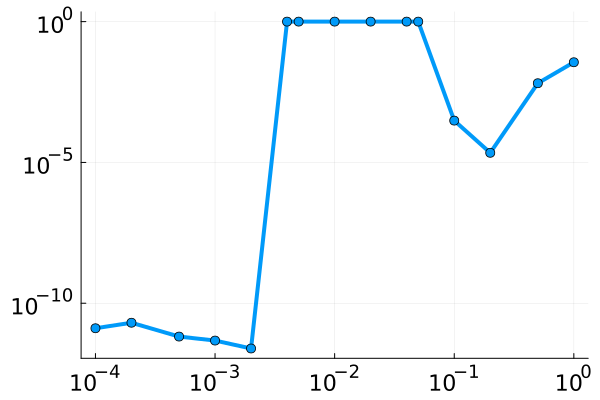

In [91]:
p_e=Plots.plot();
p_e=plot!(Delta_x.*(-1),vec(err),lw=4,legend=false,marker=(:circle,5),xtickfontsize=15,ytickfontsize=15,legendfontsize=10,
    xaxis=:log,yaxis=:log)

The gap is about $[-0.1,-0.004]$ for BDF6.